## Import CIF files

In [1]:
import os
import pymatgen.io.cif as cif
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import pandas as pd

databases = ['mp', 'csd']
chalcogens = ['S', 'Se', 'Te']

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

structure_dict = {'cif_filename': [], 'source': [], 'chalcogen': [], 'structure': [], 'crystal_system': [], 'point_group': [], 'space_group': []}

cif_path = r"C:\Users\Tuong\Desktop\urop\cif_files"
# for database in databases:
for database in ['mp']:
# for database in ['csd']:
    for chalcogen in ['S']:
    # for chalcogen in chalcogens:
        print(database, chalcogen)
        i = 0
        os.chdir(rf"{cif_path}\{database}\{chalcogen}")
        cif_filenames = os.listdir(os.getcwd())
        for cif_filename in cif_filenames:
            cif_parser = cif.CifParser(cif_filename, occupancy_tolerance=100)
            structure = cif_parser.get_structures(primitive=False)[0]
            
            structure_dict['cif_filename'].append(cif_filename)
            structure_dict['source'].append(database)
            structure_dict['chalcogen'].append(chalcogen)
            structure_dict['structure'].append(structure)
            
            # sga = SpacegroupAnalyzer(structure, symprec=0.1)
            # structure_dict['crystal_system'].append(sga.get_crystal_system())
            # structure_dict['point_group'].append(sga.get_point_group_symbol())
            # structure_dict['space_group'].append(sga.get_space_group_number())

            
            i += 1
            if i % 100 == 0:
                print(database, chalcogen, i, "cif files processed")
        
            
print("done")
# warnings.resetwarnings()

# what does this do again? 
num_entries = len(structure_dict['cif_filename'])
keys_to_del = []
for key, val in structure_dict.items():
    if len(val) < num_entries:
        keys_to_del.append(key)
for key in keys_to_del:        
    del structure_dict[key]

structure_df = pd.DataFrame(data=structure_dict).drop_duplicates(subset=['cif_filename']) # multi-chalcogen structs are labeled as S

mp S


C:\Users\Tuong\anaconda3\lib\site-packages\pymatgen\io\cif.py:1167: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


mp S 100 cif files processed
mp S 200 cif files processed
mp S 300 cif files processed
mp S 400 cif files processed
mp S 500 cif files processed
mp S 600 cif files processed
done


In [204]:
structure_df

cif_filename source chalcogen  \
0    mp-1025333.cif     mp         S   
1      mp-10488.cif     mp         S   
2    mp-1065204.cif     mp         S   
3    mp-1077811.cif     mp         S   
4    mp-1078562.cif     mp         S   
..              ...    ...       ...   
664     mp-9770.cif     mp         S   
665   mp-984714.cif     mp         S   
666   mp-985828.cif     mp         S   
667     mp-9900.cif     mp         S   
668   mp-990091.cif     mp         S   

                                             structure  
0    [[ 1.09347445  2.38409058 -1.35379607] Ag, [0....  
1    [[4.67172485e+00 4.67172485e+00 5.72121288e-16...  
2    [[ 4.20830686  2.51977939 17.84506956] Cr, [0....  
3    [[0.70029831 1.94084204 1.77992975] Cu, [1.394...  
4    [[3.30358726e-16 2.05431300e+00 7.70530478e+00...  
..                                                 ...  
664  [[ 7.43555055  0.93618811 11.75293977] Ag, [ 6...  
665  [[ 0.99224275  5.68228014 10.07858305] Ag, [0....  
666  [[2.01741500e+00 2.01741500e+00 2.47062082e-16...  
667  [[3.14775718 1.8438374  5.83699258] Ag, [ 6.37...  
668  [[0.68806467 5.889042   0.55092354] Ag, [ 6.69...  

[669 rows x 4 columns]

## Define Bispectra

In [3]:
# can't import these before queries or else it breaks
import numpy as np
import matplotlib.pyplot as plt
import plotly 
import plotly.graph_objects as go
import pandas as pd

import torch
import e3nn
from e3nn import o3, io
from tqdm import tqdm

In [103]:
lmax=4
sph = io.SphericalTensor(lmax, p_val=1, p_arg=-1)

bispectrum = o3.ReducedTensorProducts(
    'ijk=jik=ikj', i=sph, 
    filter_ir_out=['0e', '0o'], 
    filter_ir_mid=o3.Irrep.iterator(lmax)
)

bispectrum_lambda = lambda x: bispectrum(x, x, x)

In [404]:
# lmax = 4
# sph = io.SphericalTensor(lmax, p_val=1, p_arg=-1)
# ts = o3.TensorSquare(sph, filter_ir_out=o3.Irrep.iterator(lmax))
# ftp = o3.FullTensorProduct(sph, ts.irreps_out.simplify(), filter_ir_out=['0e', '0o'])
# bispectrum_lambda = lambda x: ftp(x, ts(x),)

C:\Users\Tuong\anaconda3\lib\site-packages\torch\jit\_check.py:181: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.



## Get relative distances for enviroments, spherical harmonic signals, and bispectra

In [5]:
from pymatgen.analysis.local_env import get_neighbors_of_site_with_index

In [6]:
# returns index of all silver atoms in structure
def get_ag(struct):
    return [i for i, site in enumerate(struct) if ('Ag' in site or str(site.specie) == 'Ag')]

# returns min_dist between silver atoms
# error if there is one silver atom
def get_ag_min_dist(struct):
    ags = get_ag(struct)
    min_dist = None
    for i, ag in enumerate(ags):
        distances = [struct.get_distance(ag, j) for j in ags[i+1:]]
        distances.sort()
        if min_dist is None:
            min_dist = distances[0]
        elif len(distances) != 0 and distances[0] < min_dist:
            min_dist = distances[0]
    return min_dist


# return dictionary of nearest chalcogens
def get_relative_S_Se_Te(struct, cutoff_method='radial', radius=3, tol=0.1):
    '''
    cutoff_method: either 'radial', 'min_dist' (uses the MinimumDistanceNN class), or 'voronoi' (uses the VoronoiNN class)
    '''
    ags = get_ag(struct)
    envs = []
    for ag in ags:
        if cutoff_method == 'radial':
            ns = struct.get_neighbors(struct[ag], radius) # ns is a list of pymatgen.core.structure.Neighbor objects
        else:
            ns = get_neighbors_of_site_with_index(struct, ag, approach=cutoff_method, delta=tol)
        ns = [n for n in ns if str(n.specie) in ['S', 'Se', 'Te']]
        if len(ns) > 0:
            coords = np.stack([n.coords for n in ns], axis=0) - struct[ag].coords.reshape(1, 3)
            envs.append((ag, coords))
    return envs

## Calculate average minimum distance between silver atoms in structures with >=2 silver atoms

In [ ]:
min_dists = {}
min_dists_avgs = {}

# for database in databases:
for database in ['mp']:
    min_dists[database] = {}
    min_dists_avgs[database] = {}
    for chalcogen in chalcogens:
        min_dists[database][chalcogen] = []
        for i, structure in enumerate(structures[database][chalcogen]):
            ags = get_ag(structure)
            if len(ags) >= 2:
                min_dists[database][chalcogen].append(get_ag_min_dist(structure))
        min_dist_avg = np.average(min_dists[database][chalcogen])
        min_dists_avgs[database][chalcogen] = round(min_dist_avg, 2)
        print(f"{database} Ag+{chalcogen} average min dist: {min_dist_avg}") 

In [ ]:
n_rows, n_cols = 1, 3
fig, ax = plt.subplots(n_rows, n_cols, figsize=(5*n_cols,5*n_rows))
database = 'mp'
for j in range(n_cols):
    chalcogen = chalcogens[j]
    dists = min_dists[database][chalcogen]
    ax[j].hist(dists, bins=np.linspace(2, 8, 31)) # overflow exluded
    # ax[j].legend(chalcogen[j], loc="upper right")      

In [1089]:
test_entry = joined_df.iloc[0]
test_struct = test_entry.structure
test_ag_site = test_entry.ag_site_index
test_cif_filename = test_entry.cif_filename

## Ag to Chalcogen Distances

In [292]:
AgS = np.array([])
max_dist = 4
num_bins = 100

for i, entry in structure_df[structure_df.chalcogen == 'S'].iterrows():
    for ag, env in get_relative_S_Se_Te(entry.structure, radius=max_dist):
        AgS = np.concatenate((AgS, np.linalg.norm(env, axis=1)))
        
AgSe = np.array([])
for i, entry in structure_df[structure_df.chalcogen == 'Se'].iterrows():
    for ag, env in get_relative_S_Se_Te(entry.structure, radius=max_dist):
        AgSe = np.concatenate((AgSe, np.linalg.norm(env, axis=1)))
        
AgTe = np.array([])
for i, entry in structure_df[structure_df.chalcogen == 'Te'].iterrows():
    for ag, env in get_relative_S_Se_Te(entry.structure, radius=max_dist):
        AgTe = np.concatenate((AgTe, np.linalg.norm(env, axis=1)))
        
dist_df = pd.DataFrame(data = {'cluster_index': len(AgS)*[0]+len(AgSe)*[1]+len(AgTe)*[2], 'distances': np.concatenate((AgS, AgSe, AgTe))})

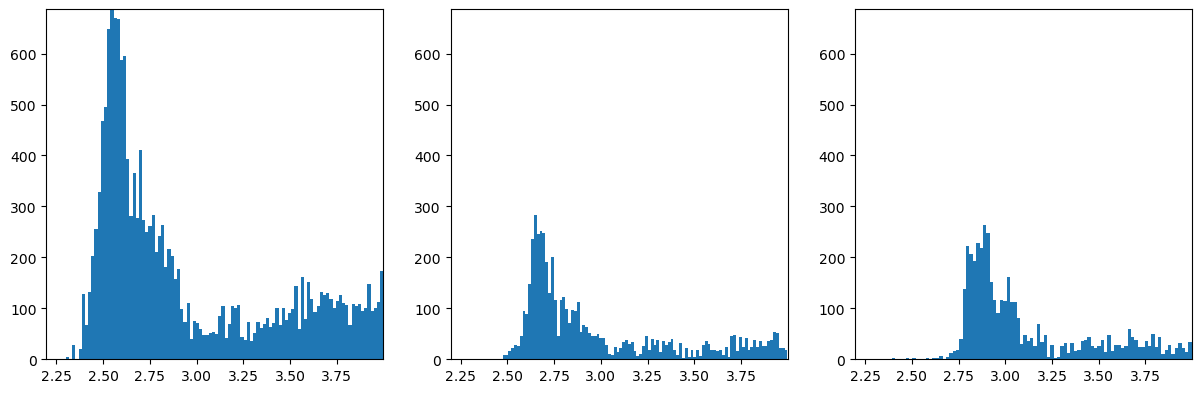

In [295]:
clusters_plotter(dist_df, 'distances', num_bins=num_bins)

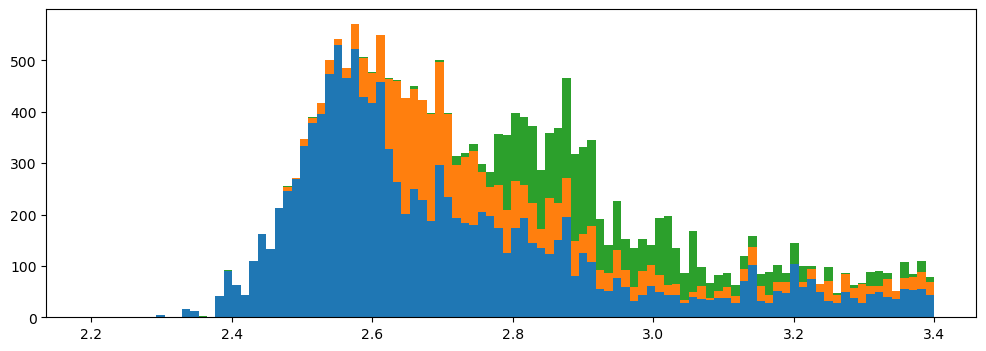

In [1188]:
cumulative_plotter(dist_df, 'distances', num_bins=num_bins)

## Calculating & Clustering the Bispectra

In [7]:
from sklearn.cluster import KMeans

In [8]:
def make_environment_df(structure_df, chalcogens=['S', 'Se', 'Te'], cutoff_method='min_dist', tol=0.1, radius=3):
    
    environment_dict = {'cif_filename': [], 'ag_site_index': [], 'environment': [], 'signal': [], 'bispectrum': []}
    
    for i, entry in tqdm(structure_df[structure_df['chalcogen'].isin(chalcogens)].iterrows()):
        # only environments with envs with a chalcogen, since get_relative with return [] otherwise
        for ag, env in get_relative_S_Se_Te(entry.structure, radius=3, cutoff_method=cutoff_method, tol=tol): # radius only used if cutoff_method == 'radial'
            environment_dict['cif_filename'].append(entry.cif_filename)
            environment_dict['ag_site_index'].append(ag)
            environment_dict['environment'].append(env)
            signal = sph.with_peaks_at(torch.tensor(env))
            environment_dict['signal'].append(signal)
            bispectrum = bispectrum_lambda(signal.to(torch.float32))
            bispectrum /= np.linalg.norm(bispectrum)
            environment_dict['bispectrum'].append(bispectrum.numpy())
            environment_df = pd.DataFrame(data=environment_dict)   
            
    return environment_df

environment_df = make_environment_df(structure_df, chalcogens=['S'], cutoff_method='radial', radius=3.1)

669it [01:11,  9.32it/s]


In [9]:
def cluster_bispectra(structure_df, environment_df, n_clusters=8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(list(environment_df.bispectrum)) # add code to test different seeds and choose best one
    kmeans.score(list(environment_df.bispectrum))
    environment_df['cluster_index'] = kmeans.labels_
    return kmeans, environment_df.set_index('cif_filename').join(structure_df.set_index('cif_filename')).reset_index()
    
kmeans, df = cluster_bispectra(structure_df, environment_df, n_clusters=8)

In [203]:
df

cif_filename  ag_site_index  \
519   mp-1201221.cif              3   
800   mp-1215421.cif              1   
811   mp-1216540.cif              1   
915   mp-1225516.cif              1   
975   mp-1229005.cif              0   
...              ...            ...   
2114     mp-4762.cif             11   
2117     mp-4762.cif             14   
2108     mp-4762.cif              5   
2109     mp-4762.cif              6   
2110     mp-4762.cif              7   

                                            environment  \
519   [[-2.540389461522, 0.0, 0.0], [-8.881784197001...   
800   [[-1.9444380000000003, -1.944438, -2.381249772...   
811   [[-0.3570092354616793, -2.5547758452507243, -1...   
915   [[-0.3539270756484185, -2.5604996347760594, -1...   
975   [[-1.9600590000000002, -1.960059, -2.400379980...   
...                                                 ...   
2114  [[-2.60449115179, -0.1254665301760003, -0.6430...   
2117  [[-2.6044911517899996, 0.1254665301760003, -0....   
2108  [[-2.6044911517899996, -0.1254665301760003, 0....   
2109  [[-0.8701558482099996, -0.12546653017600007, 2...   
2110  [[-0.87015584821, -1.111723583204, 2.100589684...   

                                                 signal  \
519   [tensor(1.4409, dtype=torch.float64), tensor(-...   
800   [tensor(1.5602, dtype=torch.float64), tensor(3...   
811   [tensor(1.5973, dtype=torch.float64), tensor(-...   
915   [tensor(1.5972, dtype=torch.float64), tensor(-...   
975   [tensor(1.5662, dtype=torch.float64), tensor(1...   
...                                                 ...   
2114  [tensor(1.1405, dtype=torch.float64), tensor(-...   
2117  [tensor(1.1405, dtype=torch.float64), tensor(-...   
2108  [tensor(1.1405, dtype=torch.float64), tensor(-...   
2109  [tensor(1.1405, dtype=torch.float64), tensor(0...   
2110  [tensor(1.1405, dtype=torch.float64), tensor(0...   

                                             bispectrum  cluster_index source  \
519   [0.0, 0.26860416, 2.1129958e-32, 4.9198726e-32...              0     mp   
800   [-6.416972e-34, 0.26860413, 1.8020919e-32, 2.6...              0     mp   
811   [1.7477848e-20, 0.2686185, 8.37428e-33, 1.0373...              0     mp   
915   [5.3791962e-20, 0.26862, 2.798761e-32, 1.14391...              0     mp   
975   [-4.655214e-34, 0.26859972, 3.6440848e-32, 3.1...              0     mp   
...                                                 ...            ...    ...   
2114  [0.005211297, 0.28218123, 0.015017338, 0.30172...              7     mp   
2117  [-0.005211297, 0.28218123, 0.015017338, 0.3017...              7     mp   
2108  [-0.005211297, 0.28218123, 0.015017338, 0.3017...              7     mp   
2109  [-0.005211297, 0.28218123, 0.015017338, 0.3017...              7     mp   
2110  [-0.005211297, 0.28218123, 0.015017338, 0.3017...              7     mp   

     chalcogen                                          structure      pca1  \
519          S  [[5.08262900e+00 0.00000000e+00 3.11221267e-16...  0.505631   
800          S  [[1.944438 1.944438 2.752739] Yb, [0. 0. 0.] A...  0.505631   
811          S  [[2.7489595  1.69289336 8.69873342] Tm, [0. 0....  0.505626   
915          S  [[2.7563906  1.69804765 8.69863846] Er, [0. 0....  0.505626   
975          S  [[0. 0. 0.] Ag, [1.960059  1.960059  2.7402475...  0.505664   
...        ...                                                ...       ...   
2114         S  [[1.7373235  0.         8.05720281] Tl, [5.211... -0.239522   
2117         S  [[1.7373235  0.         8.05720281] Tl, [5.211... -0.239522   
2108         S  [[1.7373235  0.         8.05720281] Tl, [5.211... -0.239522   
2109         S  [[1.7373235  0.         8.05720281] Tl, [5.211... -0.239522   
2110         S  [[1.7373235  0.         8.05720281] Tl, [5.211... -0.239522   

          pca2                                     normalized_bis      dots  
519   0.549349  [-0.0, 0.980591, 7.276478e-31, 2.8345196e-31, ...  0.332370  
800   0.549349  [5.6849453e-30, 0.9805909, 

## PCA

In [10]:
from sklearn.decomposition import PCA

In [320]:
bis = np.array([np.array(b) for b in df.bispectrum])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(bis)
print(X_pca.shape)
df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

(3061, 2)


In [321]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(bis)

In [46]:
X_pca.shape

(3061, 2)

In [28]:
pca.components_.shape

(5, 15)

In [29]:
X_pca_bleh = [X_pca[:, i] for i in range(X_pca.shape[-1])]

In [322]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))


[0.5003923  0.22978966 0.11075624 0.06683467 0.0384404 ]
0.9462132900953293


0 1
0 2
0 3
1 2
1 3
2 3


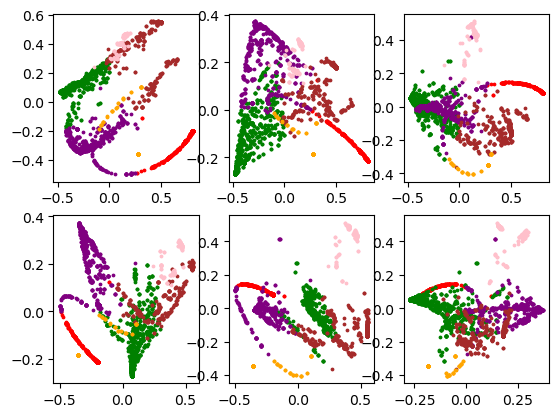

In [29]:
import itertools

nrows = 2
ncols = 3

fig, ax = plt.subplots(nrows, ncols)
colors = ["red", "green", "purple", "brown", "pink", "orange", "blue", "yellow"]
# fig, ax = plt.subplots(figsize = (9, 6))
# ax.set_xscale("log")
# ax.set_yscale("log")
for k, (i,j) in enumerate(itertools.combinations(range(4), 2)):
    print(i, j)
    row = int(k/ncols)
    col = int(k%ncols)
    # print(k, row, col)
    for c, color in enumerate(colors):
        cluster_indices = environment_df[environment_df.cluster_index == c].index
        ax[row, col].scatter(X_pca[cluster_indices, i], X_pca[cluster_indices, j], color=color, s=3)
    

# plt.title('PCA of the Bispectra')
# plt.xlabel('1st Component of PCA')
# plt.ylabel('2nd Component of PCA')

Text(0, 0.5, '2nd Component of PCA')

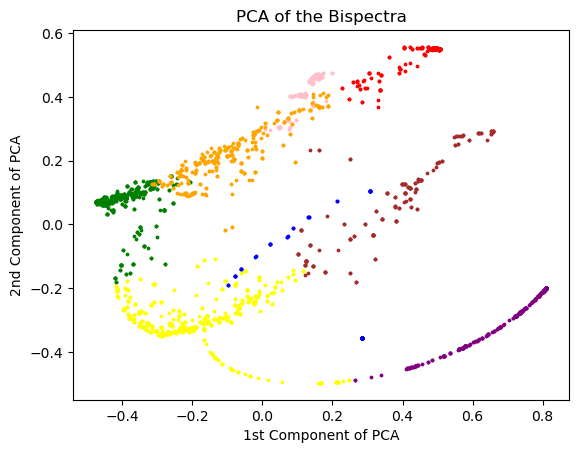

In [12]:
fig = plt.figure()
colors = ["red", "green", "purple", "brown", "pink", "orange", "blue", "yellow"]
# fig, ax = plt.subplots(figsize = (9, 6))
# ax.set_xscale("log")
# ax.set_yscale("log")
for i, color in enumerate(colors):
    plt.scatter(df[df.cluster_index == i].pca1, df[df.cluster_index == i].pca2, color=color, s=3)
    

plt.title('PCA of the Bispectra')
plt.xlabel('1st Component of PCA')
plt.ylabel('2nd Component of PCA')
# opacity 

In [141]:
environment_df[(0.2 < environment_df.pca1) & (environment_df.pca1 < 0.3) & (-0.35 < environment_df.pca2) & (environment_df.pca2 < -0.25) & (environment_df.cluster_index == 4)]
# environment_df[(0.2 < environment_df.pca1) & (environment_df.pca1 < 0.3) & (0.1 < environment_df.pca2) & (environment_df.pca2 < 0.2) & (environment_df.cluster_index == 4)]
# environment_df[environment_df.cluster_index == 4]

cif_filename  ag_site_index  \
5     mp-1065204.cif              1   
22    mp-1094066.cif              1   
39    mp-1096795.cif              1   
40    mp-1096820.cif              1   
41    mp-1096969.cif              1   
...              ...            ...   
2785   mp-677726.cif             38   
2786   mp-677726.cif             39   
2837   mp-685999.cif              0   
2839   mp-685999.cif              2   
2909     mp-7885.cif              1   

                                            environment  \
5     [[0.5597149748987229, 0.33513674401077576, 2.3...   
22    [[-0.6228078751399648, -0.3770404194590493, -2...   
39    [[0.6536084060465825, 0.3974020969910065, 2.31...   
40    [[0.5901021962411435, 0.35523462029697433, 2.3...   
41    [[-0.577049484137361, -0.3464354946900534, -2....   
...                                                 ...   
2785  [[1.4295323238377913, -1.3084103907388311, 1.4...   
2786  [[0.6326602261673493, 1.6085510832073968, -1.6...   
2837  [[0.9110122177626749, 0.6565746835293842, -2.4...   
2839  [[-0.9110122177626749, -0.656574683529384, 2.4...   
2909                      [[0.0, 0.0, -2.445523142611]]   

                                                 signal  \
5     [tensor(0.3490, dtype=torch.float64), tensor(0...   
22    [tensor(0.3432, dtype=torch.float64), tensor(-...   
39    [tensor(0.3459, dtype=torch.float64), tensor(0...   
40    [tensor(0.3449, dtype=torch.float64), tensor(0...   
41    [tensor(0.3481, dtype=torch.float64), tensor(-...   
...                                                 ...   
2785  [tensor(0.3407, dtype=torch.float64), tensor(0...   
2786  [tensor(0.3421, dtype=torch.float64), tensor(0...   
2837  [tensor(0.3829, dtype=torch.float64), tensor(0...   
2839  [tensor(0.3829, dtype=torch.float64), tensor(-...   
2909  [tensor(0.3468, dtype=torch.float64), tensor(0...   

                                             bispectrum  cluster_index  \
5     [-2.5687347e-10, 0.05176058, 0.15528172, 0.200...              4   
22    [3.1632164e-09, 0.051760577, 0.15528171, 0.200...              4   
39    [2.722835e-09, 0.05176057, 0.15528171, 0.20046...              4   
40    [3.4562053e-10, 0.051760577, 0.15528171, 0.200...              4   
41    [9.318233e-10, 0.051760573, 0.1552817, 0.20046...              4   
...                                                 ...            ...   
2785  [1.4195658e-09, 0.051760577, 0.15528171, 0.200...              4   
2786  [-1.2048909e-09, 0.051760565, 0.1552817, 0.200...              4   
2837  [4.802767e-09, 0.05176057, 0.15528172, 0.20046...              4   
2839  [-4.802767e-09, 0.05176057, 0.15528172, 0.2004...              4   
2909  [0.0, 0.051760573, 0.15528171, 0.20046784, 0.2...              4   

          pca1      pca2  
5     0.268123 -0.300681  
22    0.268122 -0.300681  
39    0.268122 -0.300681  
40    0.268123 -0.300681  
41    0.268123 -0.300681  
...        ...       ...  
2785  0.268123 -0.300681  
2786  0.268123 -0.300681  
2837  0.268122 -0.300681  
2839  0.268122 -0.300681  
2909  0.268123 -0.300681  

[115 rows x 8 columns]

In [485]:
X_pca[0]

array([-1.7299054 ,  2.888968  , -2.8992646 ,  1.3679382 ,  0.9025467 ,
       -0.38148147, -0.03012659,  0.00608518, -0.07154479,  0.08396046,
       -0.1428102 ,  0.02937549,  0.07778776, -0.02841579, -0.01169992],
      dtype=float32)

In [486]:
bis[0]

array([ 1.7466197e-08,  2.3131232e+00,  1.9640965e-21,  3.3409959e-01,
        5.3148928e+00,  2.7076902e+00, -2.5131665e-22,  2.3292938e-19,
        2.1443934e-20,  4.4522755e-02, -2.2697642e-01,  2.6900269e-08,
        3.0520317e-01,  4.7949657e+00, -1.0159391e+00], dtype=float32)

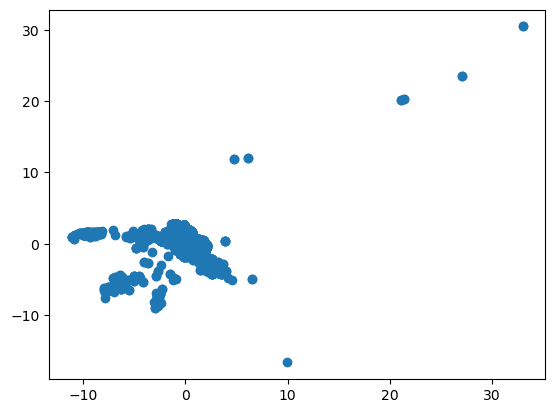

In [478]:
plt.scatter(X_pca[:,0], X_pca[:,1])

In [467]:
pca = PCA(n_components=3)

In [468]:
X_pca = pca.fit_transform(bis)

[0.88521534 0.04755581 0.03522727]


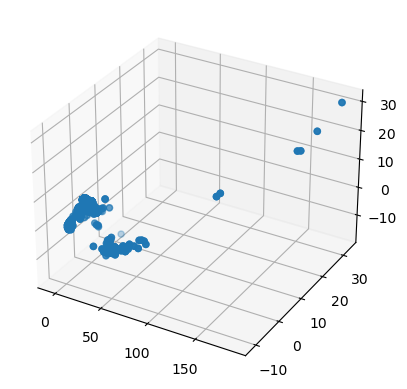

In [471]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
print(pca.explained_variance_ratio_)
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2])

## Number of Local Environments vs Cutoff Distance

In [ ]:
# def bis_norms(cutoff):
#     env_dict = {}
#     for i, s in enumerate(structures[database][chalcogen]):
#         mid = mids[database][chalcogen][i]
#         envs = get_relative_S_Se_Te(s, max_dist=cutoff) # change this
#         sigs = [sph.with_peaks_at(torch.tensor(env)) for env in envs]
#         env_dict[mid] = {'envs': envs, 'sigs': sigs}
#     all_sigs = []
#     for v in env_dict.values():
#         all_sigs += v['sigs']
#     # try:
#     AgS = torch.stack(all_sigs, dim=0)
#     AgS_norm = AgS / AgS.norm(dim=-1, keepdim=True)
#     bis = bispectrum_lambda(AgS.to(torch.float32))
#     bis_norm = bis / bis.norm(dim=-1, keepdim=True)
#     return bis_norm
#     # except:
#         # return 0

## Choosing the Number of Clusters

In [14]:
from sklearn.metrics import silhouette_score

max_num_clusters = 20

Inertia is the sum of the squared distances between each training instance and its closest centroid. It is also negative of the score used in `sklearn.cluster.KMeans`. Let's plot the inertia as a function of $k$.

C:\Users\Tuong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


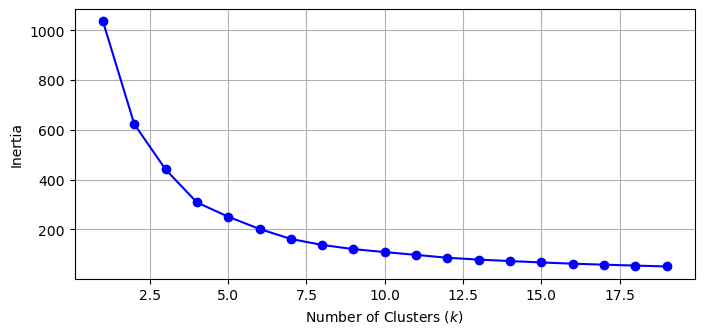

In [15]:
bis = np.array([np.array(b) for b in df.bispectrum])
kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(bis) for k in range(1, max_num_clusters)]
inertias = [model.inertia_ for model in kmeans_per_k]


plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_num_clusters), inertias, "bo-")
plt.xlabel("Number of Clusters ($k$)")
plt.ylabel("Inertia")
plt.grid()

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to (_b_ - _a_) / max(_a_, _b_) where _a_ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and _b_ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes _b_, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

C:\Users\Tuong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


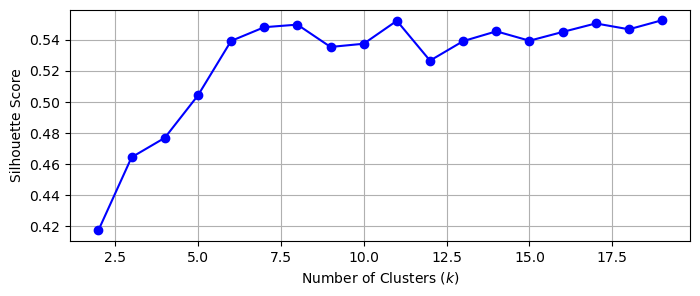

In [16]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=2).fit(bis) for k in range(1, max_num_clusters)]
silhouette_scores = [silhouette_score(bis, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, max_num_clusters), silhouette_scores, "bo-")
plt.xlabel("Number of Clusters ($k$)")
plt.ylabel("Silhouette Score")
plt.grid()

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

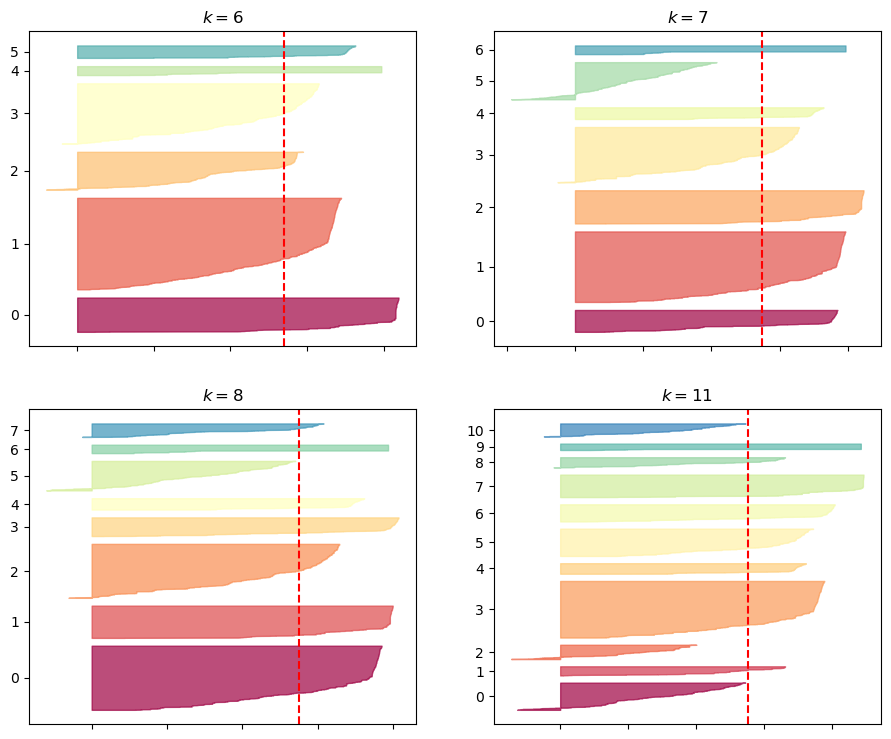

In [18]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for i, k in enumerate([6, 7, 8, 11]):
    plt.subplot(2, 2, i + 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(bis, y_pred)

    padding = len(bis) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if i in (0, 2):
        plt.ylabel("Cluster")
    
    if i in (2, 3):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

### Average intra-cluster dot product

In [297]:
intra_cluster_dots = []
for _, entry in tqdm(joined_df.iterrows()):
    intra_cluster_dots.append((entry.bispectrum @ kmeans.cluster_centers_[entry.cluster_index].T).item())
joined_df['intra_cluster_dots'] = intra_cluster_dots

3073it [00:00, 11095.54it/s]


## How much does `random_state` affect clustering?

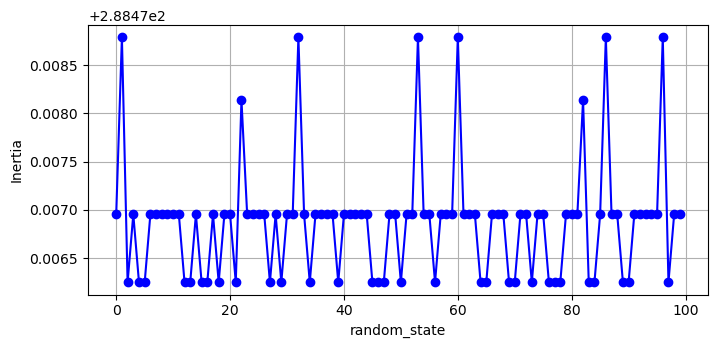

In [294]:
kmeans_per_seed = [KMeans(n_clusters=6, random_state=seed).fit(bis_norm) for seed in range(100)]
inertias = [model.inertia_ for model in kmeans_per_seed]

plt.figure(figsize=(8, 3.5))
plt.plot(range(100), inertias, "bo-")
plt.xlabel("random_state")
plt.ylabel("Inertia")
plt.grid()

## K-means Clustering Analysis

In [ ]:
# cutoffs = np.linspace(2.5, 5.4, 117)
# num_envs = []
# scores = []
# for cutoff in cutoffs:
#     print(cutoff)
#     bis_norm = bis_norms(cutoff)
#     num_envs.append(bis_norm.shape[0])
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(bis_norm)
#     scores.append(kmeans.score(bis_norm))

In [ ]:
# plt.plot(cutoffs, scores)

In [ ]:
# plt.plot(cutoffs, num_envs)

In [249]:
[(kmeans.labels_ == i).nonzero()[0].shape[0] for i in range(n_clusters)]

[245, 846, 426, 179, 151, 391, 112, 711]

(0.0, 1.0)

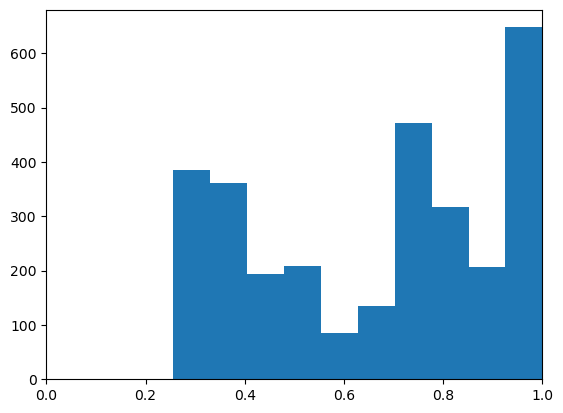

In [395]:
dots = bis_norm[0] @ bis_norm.T
n, bins, patches = plt.hist(dots)
plt.xlim(0, 1)

In [267]:
bis_norm = np.array([np.array(b) for b in df.bispectrum])

In [288]:
avg_bis = np.average(bis_norm, axis=0)

(0.0, 1.0)

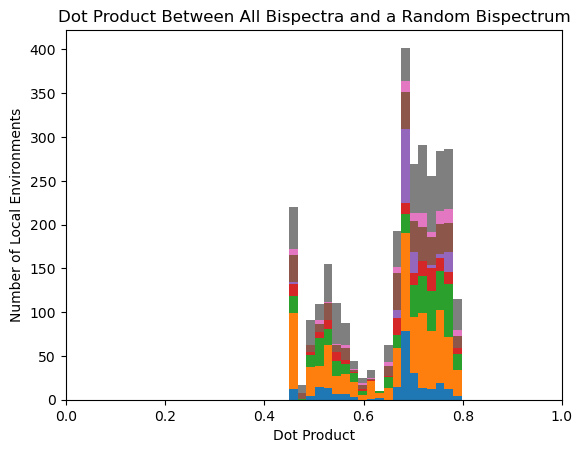

In [292]:
n_clusters = 8
clusters_dots = [(bis_norm[(kmeans.labels_ == i).nonzero()[0]] @ avg_bis.T).flatten() for i in range(n_clusters)]
# same_cluster = bis_norm[(kmeans.labels_ == first_bis_cluster).nonzero()[0]] @ first_bis.T # (-1, 15) @ (15, -1)
# diff_cluster = bis_norm[(kmeans.labels_ != first_bis_cluster).nonzero()[0]] @ first_bis.T
plt.hist(clusters_dots, stacked=True, bins=20)
plt.title('Dot Product Between All Bispectra and a Random Bispectrum')
plt.xlabel('Dot Product')
plt.ylabel('Number of Local Environments')
plt.xlim(0, 1)



In [180]:
first_bis = bis_norm[0]
dots = []
centroid = kmeans.cluster_centers_[5]
for bis in environment_df.bispectrum:
    dots.append((bis @ centroid.T).item())
environment_df['dots'] = dots
environment_df.sort_values('dots')

cif_filename  ag_site_index  \
1512  mp-1246997.cif             10   
1510  mp-1246997.cif              8   
1503  mp-1246990.cif              9   
1522  mp-1247006.cif              8   
1523  mp-1247006.cif              9   
...              ...            ...   
138   mp-1190401.cif              5   
714   mp-1215118.cif             11   
713   mp-1215118.cif             10   
728   mp-1215118.cif             25   
729   mp-1215118.cif             26   

                                            environment  \
1512  [[-1.9477585659500005, -1.7375715000000003, 1....   
1510  [[-0.3426510745810001, -1.7375715, -2.45194401...   
1503  [[-0.00983628579410789, -1.8259544908685887, -...   
1522  [[-1.79610619095, -1.9085705905480002, -1.1788...   
1523  [[-1.7961061909500002, -1.908570590548, 1.1788...   
...                                                 ...   
138   [[-0.03423954150351105, 0.3114409887468801, -2...   
714   [[0.23153193894359703, -0.8369041844016163, 2....   
713   [[-1.0368597486745674, 0.33061792322356687, 2....   
728   [[0.25692494856029136, -0.8977635581986192, 2....   
729   [[-1.0113003334361137, 0.2774777264099386, 2.3...   

                                                 signal  \
1512  [tensor(1.5144, dtype=torch.float64), tensor(0...   
1510  [tensor(1.5144, dtype=torch.float64), tensor(-...   
1503  [tensor(1.1977, dtype=torch.float64), tensor(0...   
1522  [tensor(1.2054, dtype=torch.float64), tensor(3...   
1523  [tensor(1.2054, dtype=torch.float64), tensor(0...   
...                                                 ...   
138   [tensor(0.3354, dtype=torch.float64), tensor(-...   
714   [tensor(0.3372, dtype=torch.float64), tensor(0...   
713   [tensor(0.3372, dtype=torch.float64), tensor(-...   
728   [tensor(0.3390, dtype=torch.float64), tensor(0...   
729   [tensor(0.3390, dtype=torch.float64), tensor(-...   

                                             bispectrum  cluster_index  \
1512  [tensor(8.6611e-26), tensor(-6.7364e-26), tens...              4   
1510  [tensor(2.1653e-26), tensor(-1.5398e-25), tens...              4   
1503  [tensor(-4.6042e-12), tensor(2.5579e-12), tens...              4   
1522  [tensor(9.2516e-26), tensor(-4.5546e-25), tens...              4   
1523  [tensor(-3.5583e-27), tensor(-2.8467e-26), ten...              4   
...                                                 ...            ...   
138   [tensor(-4.9479e-10), tensor(0.), tensor(4.947...              5   
714   [tensor(0.), tensor(-9.7408e-10), tensor(9.740...              5   
713   [tensor(4.8704e-10), tensor(-1.9482e-09), tens...              5   
728   [tensor(-4.8452e-10), tensor(-9.6904e-10), ten...              5   
729   [tensor(1.9381e-09), tensor(0.), tensor(-3.876...              5   

          dots  
1512  0.142563  
1510  0.142563  
1503  0.143613  
1522  0.144190  
1523  0.144190  
...        ...  
138   0.986432  
714   0.986434  
713   0.986434  
728   0.986453  
729   0.986453  

[3015 rows x 7 columns]

Text(0.5, 0.98, 'Dot Product Between All Bispectra and an Arbitrary Bispectrum Within Different Clusters')

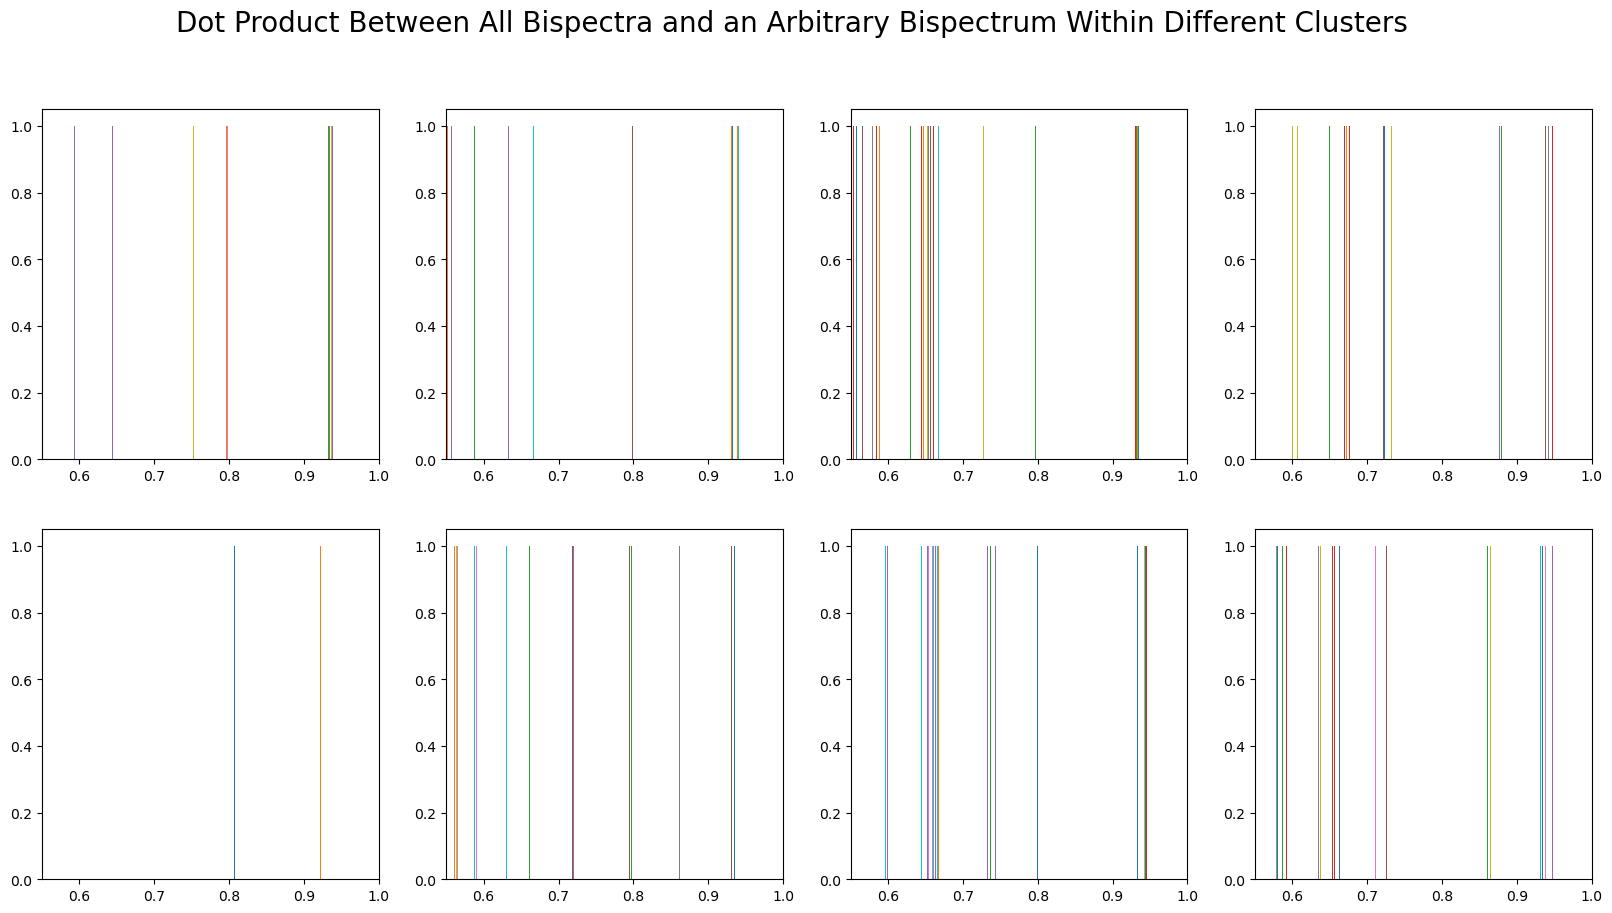

In [245]:
bis_norm = np.array([np.array(b) for b in df.bispectrum])

n_rows, n_cols = 2, 4
fig, ax = plt.subplots(n_rows, n_cols, figsize=(5*n_cols,5*n_rows))

max_in_a_bin = 0
for i in range(n_rows):
    for j in range(n_cols):
        if n_cols*i + j >= n_clusters:
            fig.delaxes(ax[i, j])
        else:
            bis_norms_for_label = bis_norm[(kmeans.labels_ == n_cols * i + j).nonzero()[0]]
            dots = bis_norms_for_label @ bis_norm[(kmeans.labels_ == n_cols * i + j).nonzero()[0]][0].reshape(1, -1).T
            n, bins, patches = ax[i, j].hist(dots.T)
            ax[i, j].set_xlim(0.55, 1)
            # max_in_a_bin = max(max_in_a_bin, max(n))
            
# for i in range(n_rows):
#     for j in range(n_cols):
#         if n_cols*i + j < n_clusters:
#             ax[i, j].set_ylim(0, max_in_a_bin)
            
fig.suptitle('Dot Product Between All Bispectra and an Arbitrary Bispectrum Within Different Clusters', fontsize=20)


In [ ]:
# first_bis = bis_norm[0]
# clusters_dots = [(bis_norm[(kmeans.labels_ == i).nonzero()[0]] @ first_bis.T).flatten() for i in range(n_clusters)]
# # same_cluster = bis_norm[(kmeans.labels_ == first_bis_cluster).nonzero()[0]] @ first_bis.T # (-1, 15) @ (15, -1)
# # diff_cluster = bis_norm[(kmeans.labels_ != first_bis_cluster).nonzero()[0]] @ first_bis.T
# plt.hist(clusters_dots, stacked=True)

# plt.xlim(0, 1)

In [257]:
df.iloc[0].bispectrum @ kmeans.cluster_centers_[1].T

0.3469814351837393

Text(0, 0.5, 'Number of Local Environments')

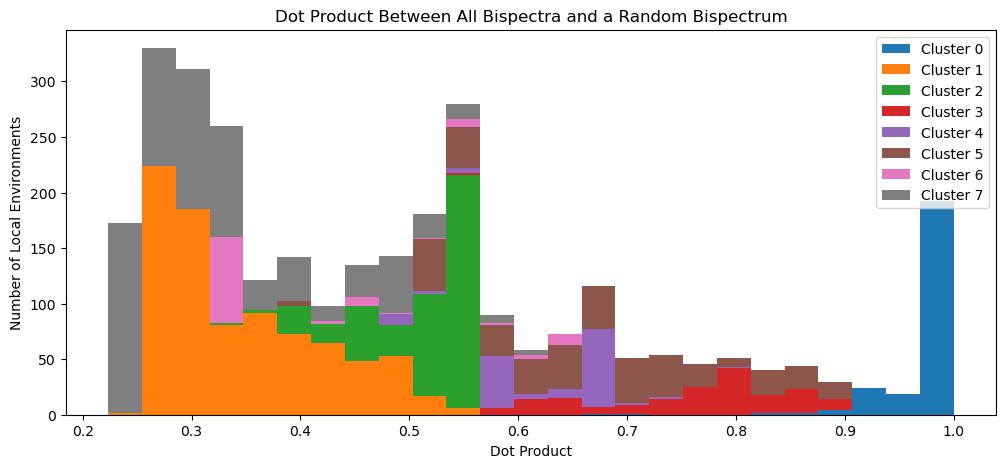

In [317]:
df['random_dots'] = df.apply(lambda row: row.bispectrum @ first_bis.T, axis=1)

legend_labels = [f"Cluster {i}" for i in range(n_clusters)]
cumulative_plotter(df, 'random_dots', num_bins=25, colors=colors, legend_labels=legend_labels, loc='upper right')
plt.title('Dot Product Between All Bispectra and a Random Bispectrum')
plt.xlabel('Dot Product')
plt.ylabel('Number of Local Environments')

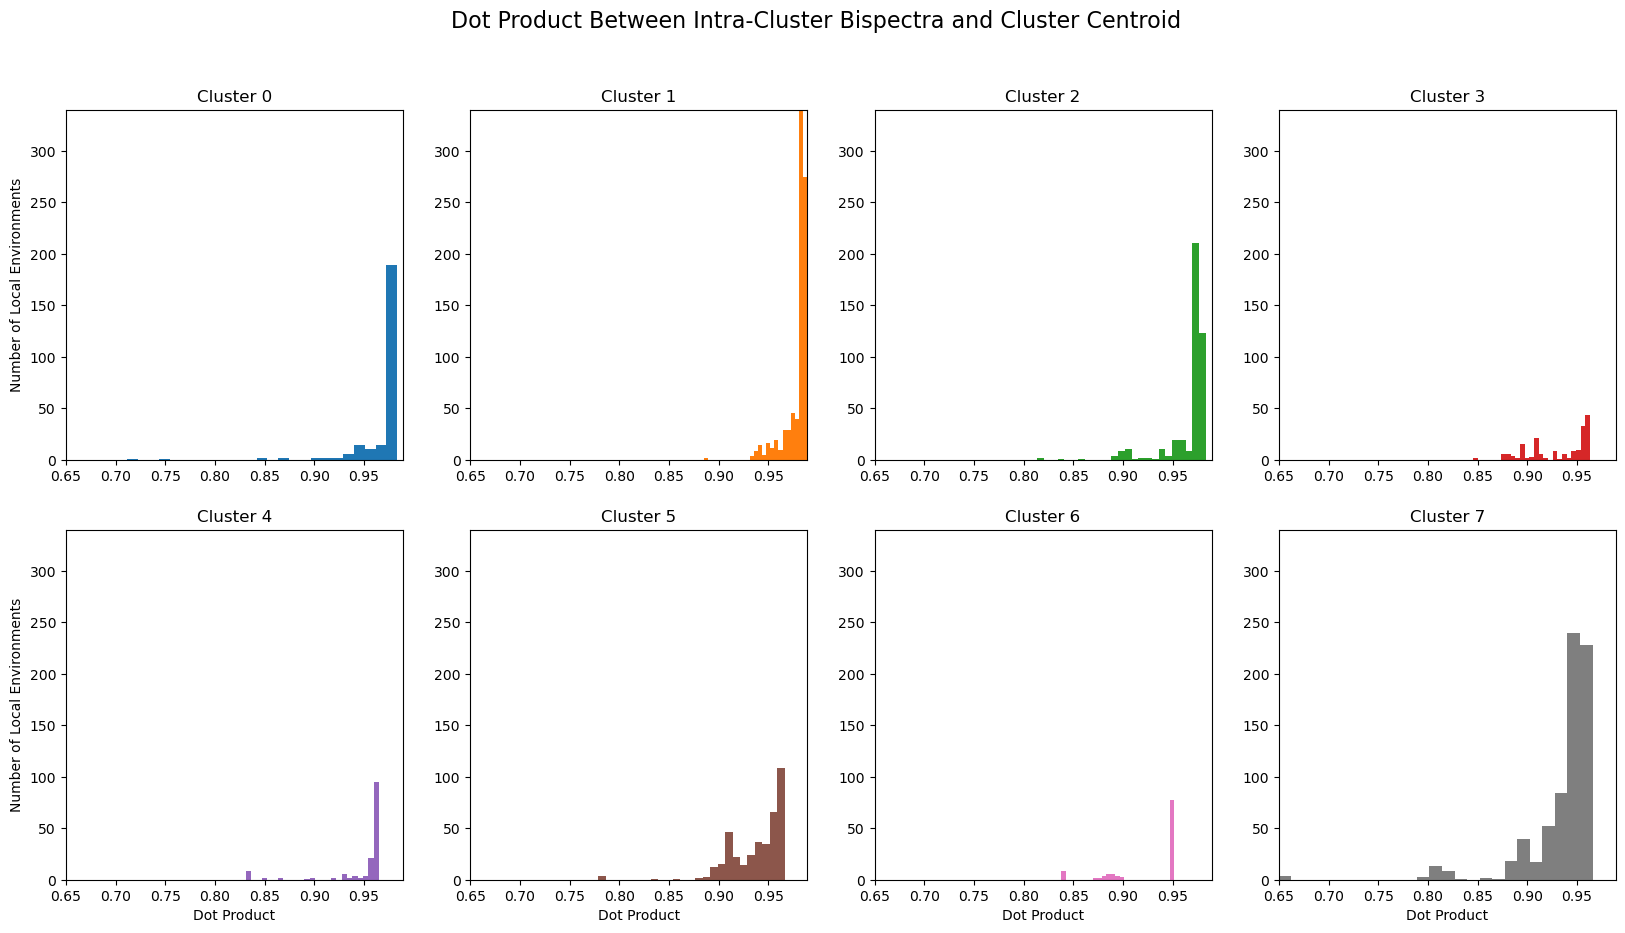

In [311]:
df['dots'] = df.apply(lambda row: row.bispectrum @ kmeans.cluster_centers_[row.cluster_index].T, axis=1)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
title = 'Dot Product Between Intra-Cluster Bispectra and Cluster Centroid'
x_labels = 4 * [''] + 4 * ['Dot Product']
y_labels = 2 * ['Number of Local Environments', '', '', '']
clusters_plotter(df, 'dots', num_bins=25, colors=colors, title=title, x_labels=x_labels, y_labels=y_labels, subplot_titles=legend_labels)

## messing around with plotting

In [154]:
import plotly.graph_objects as go
import plotly.io as pio

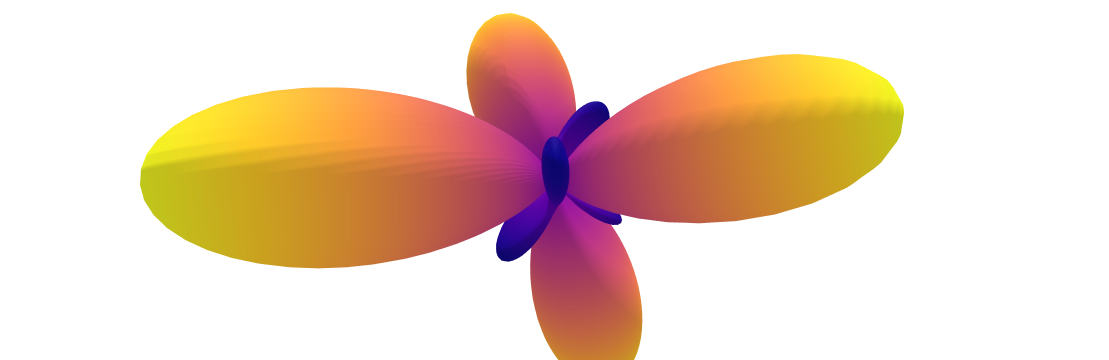

In [284]:
surface = go.Surface(**sph.plotly_surface(df.iloc[0].signal.to(torch.float32))[0], showscale=False, hoverinfo='none')

# go.Figure([go.Surface(**sph.plotly_surface(inverted_cluster_signals[cluster_index].detach())[0])])

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)', range=[-1, 1]),
        yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)', range=[-1, 1]),
        zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)', range=[-1, 1]),
        bgcolor='rgba(255,255,255,0)',
        camera=camera
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=0, r=0, t=0, b=0)
)

fig = go.Figure(data=[surface], layout=layout)

fig.show()

In [305]:
sph.plotly_surface(df.iloc[0].signal.to(torch.float32))[0]

AttributeError: 'Series' object has no attribute 'signal'

In [300]:
df = pd.DataFrame(data={'a': [1, 2], 'b': [surface, surface]})

In [304]:
df.to_csv('dataframe.csv', index=False)

## Near Neighbor Gradient Descent

In [214]:
from scipy import spatial

In [215]:
small_df = df[df.cluster_index == 7].reset_index()

In [216]:
tree = spatial.KDTree(list(small_df.bispectrum))
small_bis = np.array([np.array(b) for b in small_df.bispectrum])

In [228]:
inverted_signals = []

tree = spatial.KDTree(list(small_df.bispectrum))
n = len(small_df)
for i, row in tqdm(small_df.iterrows()):
    for ith_nearest_neighbor in range(1, n):
        try:
            nn_index = int(np.array(tree.query(small_bis, n)).T[ith_nearest_neighbor,i,1])
        except:
            print(i, row, ith_nearest_neighbor)
        guess_environment = small_df.iloc[nn_index].environment
        if row.environment.shape[0] <= guess_environment.shape[0]: # neighbor needs at least as many points in guess for inverison to work
            break
    inverted_signal = invert_bispectrum(target_bispectrum=torch.from_numpy(row.bispectrum), guess=torch.from_numpy(guess_environment).to(torch.float32), max_iter=500)
    inverted_signals.append(inverted_signal.detach())
    
small_df['inverted_signal'] = inverted_signals

433it [1:00:04,  8.32s/it]


In [229]:
import plotly.graph_objs as go
import plotly.io as pio
import numpy as np

# Create a surface plot
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x, y)
z = np.sin(np.sqrt(x_grid**2 + y_grid**2))

surface = go.Surface(
    x=x_grid,
    y=y_grid,
    z=z,
    showscale=False,
    # lighting=dict(ambient=1, diffuse=0, specular=0, roughness=1, fresnel=0)
)

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

# Modify the layout to remove axes, grid lines, and colorbar
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)'),
        yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)'),
        zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)'),
        bgcolor='rgba(255,255,255,0)',
        camera=camera
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=0, r=0, t=0, b=0)
)

In [290]:
import os

os.chdir(r'C:\Users\Tuong\Desktop\urop\notebooks\\')
if not os.path.exists("static"):
    os.mkdir("static")

image_paths = []
for i, row in tqdm(small_df.iterrows()):
    fig = go.Figure([go.Surface(**sph.plotly_surface(row.inverted_signal.detach())[0])], layout=layout)
    image_path = f"static/{row.cif_filename[:-4]}-{row.ag_site_index}.jpg"
    image_paths.append(image_path)
    pio.write_image(fig, image_path)

430it [17:53,  2.50s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'static\\mp-9770-2.jpg'

In [ ]:
small_df["image_path"] = image_paths

In [ ]:
small_df.to_csv('dataframe.csv', index=False)

In [288]:
small_df.signal

0      [tensor(0.2587, dtype=torch.float64), tensor(0...
1      [tensor(0.2587, dtype=torch.float64), tensor(-...
2      [tensor(0.2582, dtype=torch.float64), tensor(0...
3      [tensor(0.2582, dtype=torch.float64), tensor(0...
4      [tensor(0.2605, dtype=torch.float64), tensor(0...
                             ...                        
428    [tensor(0.2582, dtype=torch.float64), tensor(-...
429    [tensor(0.2608, dtype=torch.float64), tensor(-...
430    [tensor(0.2608, dtype=torch.float64), tensor(0...
431    [tensor(0.2608, dtype=torch.float64), tensor(0...
432    [tensor(0.2608, dtype=torch.float64), tensor(-...
Name: signal, Length: 433, dtype: object

In [287]:
small_df['signal'] = small_df['signal'].apply(lambda tensor: tensor / torch.norm(tensor))

## Hierarchical Clustering

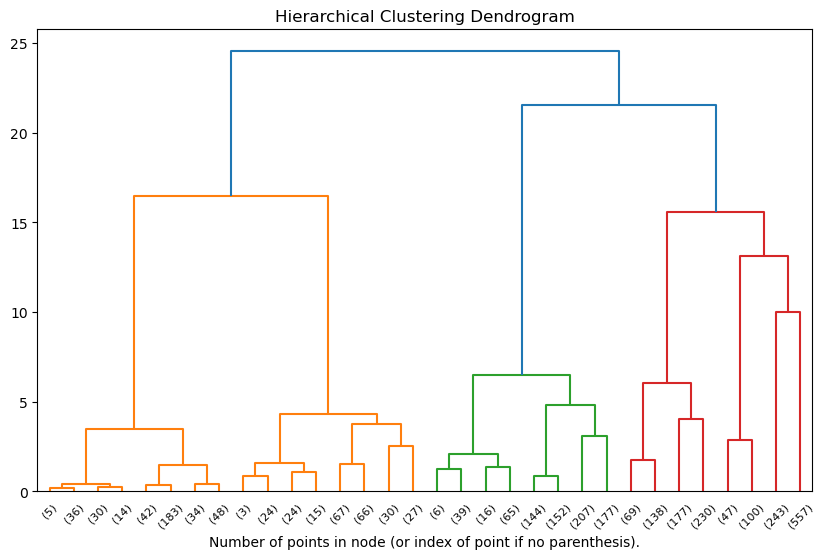

In [244]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from matplotlib.pyplot import figure
figure(figsize=(10, 6))

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)


model = model.fit(bis_norm)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



In [243]:
model

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

## Inverting Bispectra of Cluster Centroids

In [13]:
def invert_bispectrum(target_bispectrum, guess=None, max_iter=1000):
    if guess is None:
        guess = torch.randn(8, 3)
    guess.requires_grad = True
    opt = torch.optim.Adam([guess], lr=1e-2)
    # loss_fn = torch.nn.MSELoss()
    loss_fn = torch.nn.L1Loss()
    for i in range(max_iter):
        cur_sig = sph.sum_of_diracs(guess, values=guess.norm(2, -1))
        # power = powerspectrum(cur_sig)
        cur_bis = bispectrum_lambda(cur_sig)
        loss = loss_fn(target_bispectrum, cur_bis) # + loss_fn(true_power, power)
        if i % 100 == 0:
            print(loss)
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(loss)
    return cur_sig


In [17]:
inverted_cluster_signals = [invert_bispectrum(torch.from_numpy(bis)) for bis in kmeans.cluster_centers_]

In [14]:
inverted_cluster_signals = []

for bis in tqdm(kmeans.cluster_centers_):
    inverted_cluster_signal = invert_bispectrum(torch.from_numpy(bis))
    inverted_cluster_signals.append(inverted_cluster_signal)

  0%|                                                                                       | 0/8 [00:00<?, ?it/s]

tensor(0.7475, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0461, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0042, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0031, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0008, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0043, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0041, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0009, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0026, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0007, dtype=torch.float64, grad_fn=<MeanBackward0>)


 12%|█████████▉                                                                     | 1/8 [00:17<02:03, 17.62s/it]

tensor(0.0015, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.4719, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1923, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0547, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0137, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0035, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0020, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0020, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0023, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0022, dtype=torch.float64, grad_fn=<MeanBackward0>)


 25%|███████████████████▊                                                           | 2/8 [00:35<01:45, 17.66s/it]

tensor(0.0019, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.7202, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3237, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0949, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0407, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0113, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0019, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0028, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0022, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0012, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0022, dtype=torch.float64, grad_fn=<MeanBackward0>)


 38%|█████████████████████████████▋                                                 | 3/8 [00:50<01:22, 16.50s/it]

tensor(0.0034, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(2.0696, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1852, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0487, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0122, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0072, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0056, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0046, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0037, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0025, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0023, dtype=torch.float64, grad_fn=<MeanBackward0>)


 50%|███████████████████████████████████████▌                                       | 4/8 [01:06<01:05, 16.40s/it]

tensor(0.0022, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(3.8095, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.4003, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0760, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0189, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0085, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0046, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0039, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0034, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0026, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0025, dtype=torch.float64, grad_fn=<MeanBackward0>)


 62%|█████████████████████████████████████████████████▍                             | 5/8 [01:21<00:47, 15.91s/it]

tensor(0.0026, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0064, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0654, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0121, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0066, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0041, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0035, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0036, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0041, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0037, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0032, dtype=torch.float64, grad_fn=<MeanBackward0>)


 75%|███████████████████████████████████████████████████████████▎                   | 6/8 [01:37<00:31, 15.71s/it]

tensor(0.0035, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(2.2923, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2993, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0979, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0170, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0013, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0013, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0009, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0013, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0012, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0026, dtype=torch.float64, grad_fn=<MeanBackward0>)


 88%|█████████████████████████████████████████████████████████████████████▏         | 7/8 [01:51<00:15, 15.33s/it]

tensor(0.0009, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.7124, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1526, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0234, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0044, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0022, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0034, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0021, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0020, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0022, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0026, dtype=torch.float64, grad_fn=<MeanBackward0>)


100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [02:06<00:00, 15.77s/it]

tensor(0.0020, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [233]:
cluster_index = 4

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)', range=[-2.5, 2.5]),
        yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)', range=[-2.5, 2.5]),
        zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)', range=[-2.5, 2.5]),
        bgcolor='rgba(255,255,255,0)',
        aspectmode='cube'
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=0, r=0, t=0, b=0)
)


fig = go.Figure(data=[go.Surface(**sph.plotly_surface(inverted_cluster_signals[cluster_index].detach())[0])], layout=layout)
# set axes 1

# cluster 0: linear
# cluster 1: tetrahedral
# cluster 2: trigonal
# cluster 3: square pyramidal
# cluster 4: ??
# cluster 5: one neighbor, mp-676121.cif, ag 1

# n_clusters = 8
# cluster 0: octahedral, slightly square pyramidal
# cluster 1: tetrahedral
# cluster 2: linear, mp-16992.cif, ag 5
# cluster 3: T-shaped
# cluster 4: blob (highest std)
# cluster 5: see saw
# cluster 6: one neighbor
# cluster 7: trigonal
pio.write_html(fig, file='my_plotly_figure.html', auto_open=True)

In [31]:
cluster_stds = []
all_bis = np.array([np.array(b) for b in df.bispectrum])
mean_bis = np.mean(all_bis, axis=0)
df['normalized_bis'] = df.apply(lambda row: row.bispectrum / mean_bis, axis=1)

n_clusters = 8
for i in range(n_clusters):
    cluster_bis = np.array([np.array(b) for b in df[df['cluster_index'] == i].bispectrum])
    cluster_std = np.std(cluster_bis)
    cluster_stds.append(cluster_std)
    print(f"Cluster {i} standard deviation: {cluster_std:.3f}")

Cluster 0 standard deviation: 0.230
Cluster 1 standard deviation: 0.224
Cluster 2 standard deviation: 0.192
Cluster 3 standard deviation: 0.187
Cluster 4 standard deviation: 0.238
Cluster 5 standard deviation: 0.206
Cluster 6 standard deviation: 0.128
Cluster 7 standard deviation: 0.200


In [201]:
dots = []
cluster_index = 7
centroid = kmeans.cluster_centers_[cluster_index]
for bis in df.bispectrum:
    dots.append((bis @ centroid.T).item())
df['dots'] = dots
df.sort_values('dots', inplace=True)
df.iloc[-1]

cif_filename                                            mp-4762.cif
ag_site_index                                                     7
environment       [[-0.87015584821, -1.111723583204, 2.100589684...
signal            [tensor(1.1405, dtype=torch.float64), tensor(0...
bispectrum        [-0.005211297, 0.28218123, 0.015017338, 0.3017...
cluster_index                                                     7
source                                                           mp
chalcogen                                                         S
structure         [[1.7373235  0.         8.05720281] Tl, [5.211...
pca1                                                      -0.239522
pca2                                                      -0.287524
normalized_bis    [46.1681, 1.0301567, 0.51714885, 1.7383744, 1....
dots                                                       0.965672
Name: 2110, dtype: object

In [53]:
import plotly.io as pio

os.chdir(r'C:\Users\Tuong\Desktop\urop\notebooks\\')
if not os.path.exists("static"):
    os.mkdir("static")

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)', range=[-2.5, 2.5]),
        yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)', range=[-2.5, 2.5]),
        zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)', range=[-2.5, 2.5]),
        bgcolor='rgba(255,255,255,0)',
        aspectmode='cube'
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=0, r=0, t=0, b=0)
)
    
for i, inverted_cluster_signal in enumerate(inverted_cluster_signals):
    fig = go.Figure(data=[go.Surface(**sph.plotly_surface(inverted_cluster_signals[i].detach())[0])], layout=layout)
    image_path = f"static/cluster{i}.jpg"
    pio.write_image(fig, image_path)

In [178]:
import scipy

def rotation_matrix(axis, theta):
    return scipy.linalg.expm(np.cross(np.eye(3), axis * theta))

In [54]:
def tetra_to_seesaw(t):
    upper_scale = (1 - t) / 1
    lower_scale = 1 / (1 - t)
    return np.array([
        [-0.57735027 * lower_scale, -0.57735027 * lower_scale, -0.57735027],
        [ 0.57735027 * lower_scale,  0.57735027 * lower_scale, -0.57735027],
        [ 0.57735027 * upper_scale, -0.57735027 * upper_scale,  0.57735027],
        [-0.57735027 * upper_scale,  0.57735027 * upper_scale,  0.57735027],])

In [62]:
scale = 1.5
tetra_seesaw = torch.tensor([tetra_to_seesaw(i) * scale  for i in np.linspace(0, 0.5, 50)])

torch.Size([4, 3])

In [157]:
max(torch.norm(torch.flatten(tetra_seesaw, start_dim=0, end_dim=1), dim=1))

tensor(2.5981, dtype=torch.float64)

In [179]:
oct_trig = torch.tensor([oct_to_trig(i) for i in np.linspace(0, 1, 50)])

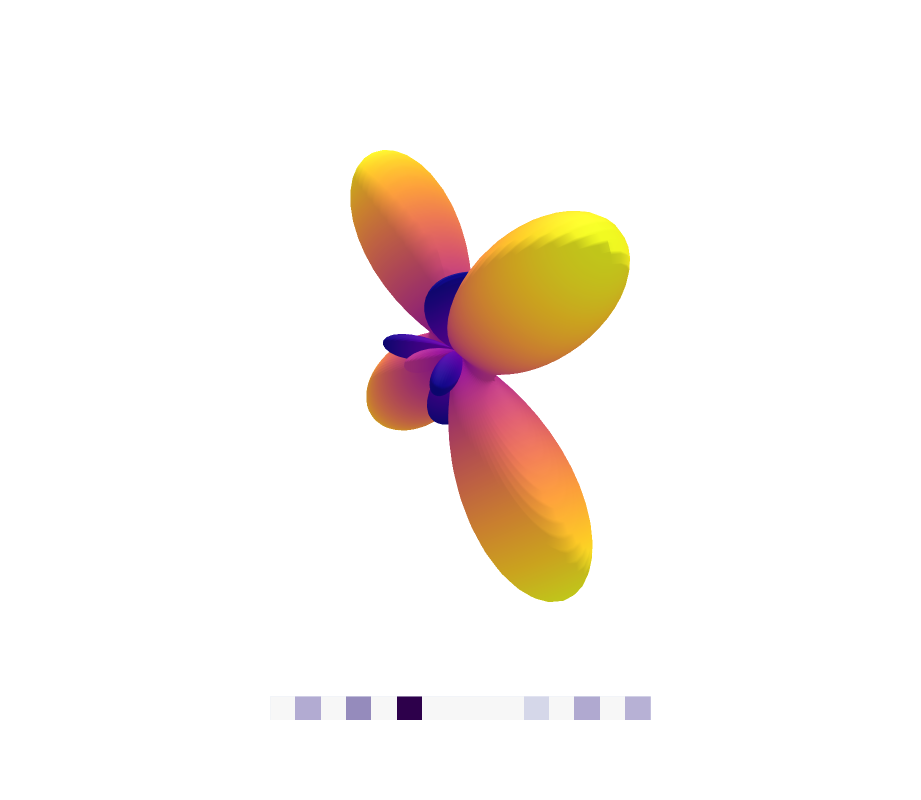

In [193]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

signal = sph.with_peaks_at(tetra_square[-1])
bis = bispectrum_lambda(signal.to(torch.float32))

# Create subplots
fig = make_subplots(rows=2, cols=1, specs=[[{'type': 'surface'}], [{'type': 'heatmap'}]], row_heights=[0.955, 0.045])

# Add surface plot to the top subplot
fig.add_trace(go.Surface(**sph.plotly_surface(signal.to(torch.float32))[0], showscale=False)) #cmin=0, cmax=2.5981))

# Add 1D heatmap to the bottom subplot
fig.add_trace(go.Heatmap(x=np.linspace(0,14,15), z=[bis], colorscale='puor', showscale=False, zmin=-1, zmax=1), row=2, col=1)

# Update layout
fig.update_layout(
    height=800,
    scene=dict(
        xaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
        yaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
        zaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
        bgcolor='rgba(255, 255, 255, 0)',  # Set transparent background
        camera=dict(
            eye=dict(x=1, y=np.sqrt(3), z=1),
        )
    )
)

fig.update_xaxes(domain=[0.25, 0.75], showgrid=False, zeroline=False, showticklabels=False, title='', row=2, col=1)
fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, title='', row=2, col=1)

# Show the figure
fig.show()


## tetrahedron to seesaw

In [171]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

scale = 1.5
tetra_seesaw = torch.tensor([tetra_to_seesaw(i) * scale  for i in np.linspace(0, 0.5, 50)])


for i in range(len(tetra_seesaw)):
    signal = sph.with_peaks_at(tetra_seesaw[i])
    bis = bispectrum_lambda(signal.to(torch.float32))

    # fig = make_subplots(rows=2, cols=1, specs=[[{'type': 'surface'}], [{'type': 'heatmap'}]], row_heights=[0.95, 0.05])
    # fig.add_trace(go.Surface(**sph.plotly_surface(signal.to(torch.float32).detach())[0]))
    # fig.add_trace(go.Heatmap(x=np.linspace(0,14,15), z=[bis], colorscale='puor', showscale=False), row=2, col=1)
    # fig.update_layout(height=800)
    # fig.update_xaxes(domain=[0.25, 0.75], row=2, col=1)
    
    # Create subplots
    fig = make_subplots(rows=2, cols=1, specs=[[{'type': 'surface'}], [{'type': 'heatmap'}]], row_heights=[0.955, 0.045])

    # Add surface plot to the top subplot
    fig.add_trace(go.Surface(**sph.plotly_surface(signal.to(torch.float32))[0], showscale=False))#, cmin=0, cmax=2.5981))

    # Add 1D heatmap to the bottom subplot
    fig.add_trace(go.Heatmap(x=np.linspace(0,14,15), z=[bis], colorscale='puor', showscale=False, zmin=-1, zmax=1), row=2, col=1)

    # Update layout
    fig.update_layout(
        height=800,
        scene=dict(
            xaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
            yaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
            zaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
            bgcolor='rgba(255, 255, 255, 0)',  # Set transparent background
            camera=dict(
                eye=dict(x=0, y=2, z=1),
            )
        )
    )

    fig.update_xaxes(domain=[0.25, 0.75], showgrid=False, zeroline=False, showticklabels=False, title='', row=2, col=1)
    fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, title='', row=2, col=1)
    
    
    image_path = f"static/{i}.jpg"
    pio.write_image(fig, image_path)
    


## octahedron to trigonal prism

In [172]:
def oct_to_trig(t):
    octa = np.array([
        [0.5, 0.5, 0.],
        [0.5, 0.5, 1.],
        [0., 0.5, 0.5],
        [1., 0.5, 0.5],
        [0.5, 0., 0.5],
        [0.5, 1., 0.5],
    ])
    octa = octa - octa.mean(0, keepdims=True)
    octa /= np.linalg.norm(octa, keepdims=True, axis=-1)
    
    # t = 0 -> oct
    # t = 1 -> trig
    rot_theta = np.pi / 6. * t
    
    # vector along current vertex
    vector_1 = np.array([1.,1.,1.])
    vector_1 /= np.linalg.norm(vector_1)
    # vector along desired vertex
    vector_2 = np.array([0.,0.,1.])
    # get rotation axis from cross product
    axis = np.cross(vector_1, vector_2)
    norm_axis = np.linalg.norm(axis)
    theta = np.arcsin(norm_axis) #  / (2 * np.pi)
    # print(theta / (2 * np.pi))

    rot_oct_matrix = rotation_matrix(axis / norm_axis, theta)
    rotated_octahedron = np.einsum('ix,xy->iy', octa, rot_oct_matrix)

    upper = rotated_octahedron[np.where(rotated_octahedron[:,2] > 0)]
    lower = rotated_octahedron[np.where(rotated_octahedron[:,2] <= 0)]

    rotated_octahedron = np.concatenate([upper, lower], axis=0)
    
    twist = rotation_matrix(np.array([0., 0., 1.]), rot_theta)
    negative_twist = rotation_matrix(np.array([0., 0., 1.]), -rot_theta)
    
    twist_upper = np.einsum('ix,xy->iy', upper, twist)
    twist_lower = np.einsum('ix,xy->iy', lower, negative_twist)
    
    return np.concatenate((twist_upper, twist_lower), axis=0)

In [187]:
oct_trig = torch.tensor([oct_to_trig(i) for i in np.linspace(0, 1, 50)])

for i in range(len(oct_trig)):
    signal = sph.with_peaks_at(oct_trig[i])
    bis = bispectrum_lambda(signal.to(torch.float32))

    # fig = make_subplots(rows=2, cols=1, specs=[[{'type': 'surface'}], [{'type': 'heatmap'}]], row_heights=[0.95, 0.05])
    # fig.add_trace(go.Surface(**sph.plotly_surface(signal.to(torch.float32).detach())[0]))
    # fig.add_trace(go.Heatmap(x=np.linspace(0,14,15), z=[bis], colorscale='puor', showscale=False), row=2, col=1)
    # fig.update_layout(height=800)
    # fig.update_xaxes(domain=[0.25, 0.75], row=2, col=1)
    
    # Create subplots
    fig = make_subplots(rows=2, cols=1, specs=[[{'type': 'surface'}], [{'type': 'heatmap'}]], row_heights=[0.955, 0.045])

    # Add surface plot to the top subplot
    fig.add_trace(go.Surface(**sph.plotly_surface(signal.to(torch.float32))[0], showscale=False))#, cmin=0, cmax=2.5981))

    # Add 1D heatmap to the bottom subplot
    fig.add_trace(go.Heatmap(x=np.linspace(0,14,15), z=[bis], colorscale='puor', showscale=False, zmin=-1, zmax=1), row=2, col=1)

    # Update layout
    fig.update_layout(
        height=800,
        scene=dict(
            xaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
            yaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
            zaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
            bgcolor='rgba(255, 255, 255, 0)',  # Set transparent background
            camera=dict(
                eye=dict(x=np.sqrt(2), y=np.sqrt(2), z=1),
            )
        )
    )

    fig.update_xaxes(domain=[0.25, 0.75], showgrid=False, zeroline=False, showticklabels=False, title='', row=2, col=1)
    fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, title='', row=2, col=1)
    
    
    image_path = f"static/{i}.jpg"
    pio.write_image(fig, image_path)
    


## tetrahedron to square

In [188]:
def tetra_to_square(t):
    axis = np.array([0, 0, 1])
    theta = t * np.pi / 4
    p_rot = rotation_matrix(axis,  theta)
    n_rot = rotation_matrix(axis, -theta)
    tetra = np.array([
        [-0.57735027, -0.57735027, -0.57735027],
        [ 0.57735027,  0.57735027, -0.57735027],
        [ 0.57735027, -0.57735027,  0.57735027],
        [-0.57735027,  0.57735027,  0.57735027],
    ])
    return np.concatenate([
        np.einsum('yx,nx->ny', p_rot, tetra[:2]),
        np.einsum('yx,nx->ny', n_rot, tetra[2:])
    ], axis=0)

In [189]:
scale = 1.5
tetra_square = torch.tensor([tetra_to_square(i) * scale  for i in np.linspace(0, 1, 50)])


In [194]:
for i in range(len(tetra_square)):
    signal = sph.with_peaks_at(tetra_square[i])
    bis = bispectrum_lambda(signal.to(torch.float32))

    # fig = make_subplots(rows=2, cols=1, specs=[[{'type': 'surface'}], [{'type': 'heatmap'}]], row_heights=[0.95, 0.05])
    # fig.add_trace(go.Surface(**sph.plotly_surface(signal.to(torch.float32).detach())[0]))
    # fig.add_trace(go.Heatmap(x=np.linspace(0,14,15), z=[bis], colorscale='puor', showscale=False), row=2, col=1)
    # fig.update_layout(height=800)
    # fig.update_xaxes(domain=[0.25, 0.75], row=2, col=1)
    
    # Create subplots
    fig = make_subplots(rows=2, cols=1, specs=[[{'type': 'surface'}], [{'type': 'heatmap'}]], row_heights=[0.955, 0.045])

    # Add surface plot to the top subplot
    fig.add_trace(go.Surface(**sph.plotly_surface(signal.to(torch.float32))[0], showscale=False))#, cmin=0, cmax=2.5981))

    # Add 1D heatmap to the bottom subplot
    fig.add_trace(go.Heatmap(x=np.linspace(0,14,15), z=[bis], colorscale='puor', showscale=False, zmin=-1, zmax=1), row=2, col=1)

    # Update layout
    fig.update_layout(
        height=800,
        scene=dict(
            xaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
            yaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
            zaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False, title=''),
            bgcolor='rgba(255, 255, 255, 0)',  # Set transparent background
            camera=dict(
                eye=dict(x=1, y=np.sqrt(3), z=1),
            )
        )
    )

    fig.update_xaxes(domain=[0.25, 0.75], showgrid=False, zeroline=False, showticklabels=False, title='', row=2, col=1)
    fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, title='', row=2, col=1)
    
    
    image_path = f"static/{i}.jpg"
    pio.write_image(fig, image_path)
    


In [83]:
tetra_seesaw[10]

tensor([[-0.9644, -0.9644, -0.8660],
        [ 0.9644,  0.9644, -0.8660],
        [ 0.7777, -0.7777,  0.8660],
        [-0.7777,  0.7777,  0.8660]], dtype=torch.float64)

In [78]:
len(tetra_seesaw)

50

In [73]:
inverted_cluster_signals[0].detach()

tensor([ 0.6785, -0.2107, -0.0309,  0.0380,  0.0312, -0.1187,  0.0248,  0.0201,
        -0.1928, -0.1891,  0.0581,  0.1444, -0.0853, -0.0406, -0.1365, -0.1732,
        -0.0841,  0.4535,  0.3781, -0.9782,  0.2138, -0.1907, -0.4022, -0.1088,
        -0.6922])

In [75]:
signal.to(torch.float32)

tensor([ 7.3625e-01,  5.5511e-17, -5.5511e-17,  1.1102e-16,  5.5511e-17,
        -1.1102e-16,  0.0000e+00, -5.5511e-17,  0.0000e+00,  2.7756e-17,
        -1.4519e+00,  1.3878e-17,  2.7756e-17,  5.5511e-17,  0.0000e+00,
        -8.3267e-17,  0.0000e+00, -5.5511e-17,  0.0000e+00,  4.1633e-17,
        -8.5896e-01,  2.7756e-17,  6.1305e-17,  5.5511e-17, -7.2595e-01])

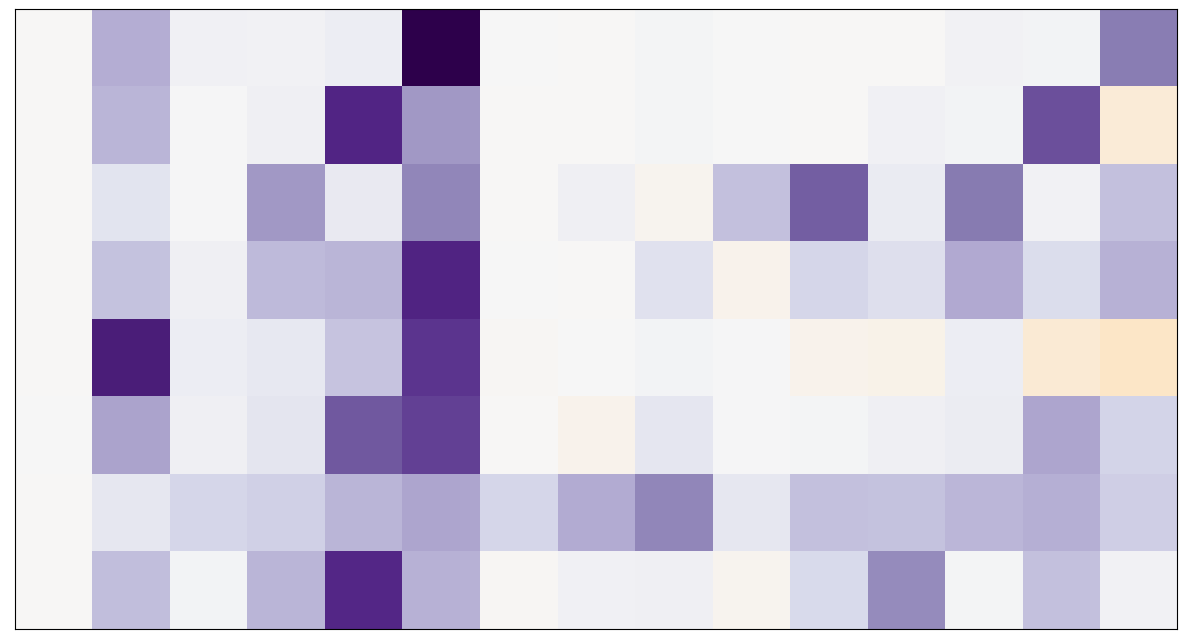

In [231]:
import matplotlib.pyplot as plt



vmax = 0.812
cluster_index = 7
fig = plt.figure(figsize=(15, 10))
plt.imshow(torch.stack([torch.from_numpy(kmeans.cluster_centers_[cluster_index]) for cluster_index in range(8)], dim=0), 
           cmap='PuOr', vmin=-vmax, vmax=vmax)

# Remove x-axis and y-axis ticks and numbers
plt.xticks([])
# plt.yticks([])
plt.yticks([]plt.yticks(range(len(kmeans.cluster_centers_[cluster_index])), range(len(kmeans.cluster_centers_[cluster_index]))))

plt.show()


In [228]:
b = kmeans.cluster_centers_.flatten()
max(abs(min(b)), max(b))

0.8116545587169882

In [227]:
max(kmeans.cluster_centers_.flatten())

0.8116545587169882

In [210]:
abs(-2)

2

first row: inverted cluster centroid

second row: actual cluster centroid

third row: closest environment to cluster centroid

## Plotters

In [316]:
def cumulative_plotter(df, variable, num_bins=None, colors=None, legend_labels=None, loc='best'):
    plt.figure(figsize=(12,5))
    n_clusters = max(df.cluster_index) + 1
    clusters_dots = [df[df.cluster_index == i][variable] for i in range(n_clusters)]
    n, bins, patches = plt.hist(clusters_dots, stacked=True, bins=num_bins, color=colors)

    if legend_labels is not None and len(legend_labels) == n_clusters:
        plt.legend(patches, legend_labels, loc=loc)
    else:
        plt.legend([f'Cluster {i}' for i in range(n_clusters)], loc=loc)


def clusters_plotter(df, variable, num_bins=None, colors=None, title=None, x_labels=None, y_labels=None, subplot_titles=None):
    n_clusters = max(df.cluster_index) + 1
    n_rows = max(2, int(np.ceil(n_clusters / 4)))
    n_cols = 4
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5*n_cols,5*n_rows))
    
    if title is not None:
        fig.suptitle(title, fontsize=16)

    min_x = min(df[variable])
    max_x = max(df[variable])
    
    max_y = 0
    for i in range(n_rows):
        for j in range(n_cols):
            cluster_idx = n_cols * i + j
            if cluster_idx >= n_clusters:
                fig.delaxes(ax[i, j])
            else:
                color = colors[cluster_idx] if colors is not None and cluster_idx < len(colors) else None
                n, bins, patches = ax[i, j].hist(df[df.cluster_index == cluster_idx][variable], bins=num_bins, color=color)
                max_y = max(max_y, max(n)) # n is the number of items in each bin

                if x_labels is not None and cluster_idx < len(x_labels):
                    ax[i, j].set_xlabel(x_labels[cluster_idx])
                if y_labels is not None and cluster_idx < len(y_labels):
                    ax[i, j].set_ylabel(y_labels[cluster_idx])
                if subplot_titles is not None and cluster_idx < len(subplot_titles):
                    ax[i, j].set_title(subplot_titles[cluster_idx])

    for i in range(n_rows):
        for j in range(n_cols):
            if n_cols*i + j < n_clusters:
                ax[i, j].set_xlim(min_x, max_x)
                ax[i, j].set_ylim(0, max_y)



                
colors = ['#1f77b4',  # blue
          '#ff7f0e',  # orange
          '#2ca02c',  # green
          '#d62728',  # red
          '#9467bd',  # purple
          '#8c564b',  # brown
          '#e377c2',  # pink
          '#7f7f7f']  # gray


## Crystal Systems, Point Groups, and Space Groups

{'monoclinic', 'hexagonal', 'cubic', 'triclinic', 'trigonal', 'tetragonal', 'orthorhombic'}


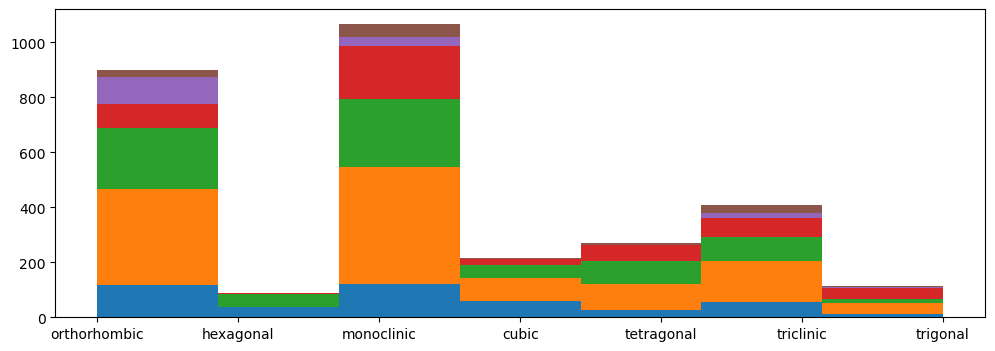

In [987]:
print(set(joined_df.crystal_system))
cumulative_plotter(joined_df, 'crystal_system', num_bins=7)

27


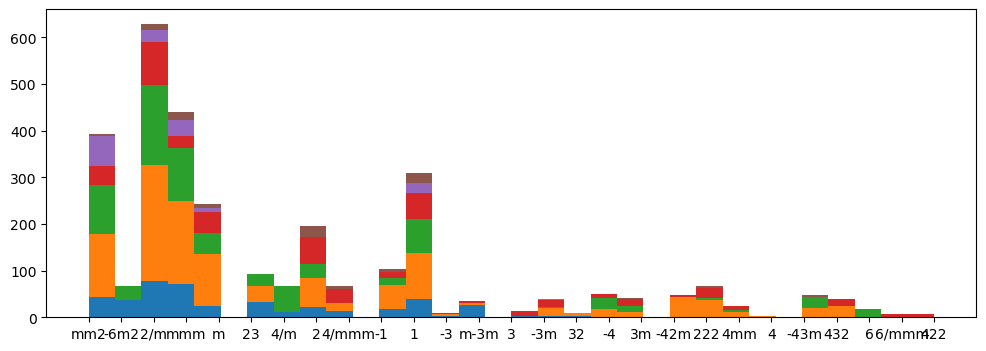

In [988]:
print(len(set(joined_df.point_group)))
cumulative_plotter(joined_df, 'point_group', num_bins=32)

86


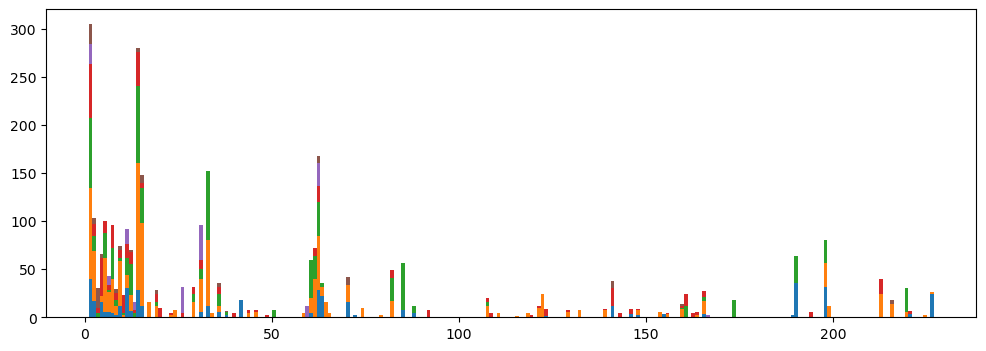

In [989]:
print(len(set(joined_df.space_group)))
cumulative_plotter(joined_df, 'space_group', num_bins=230)

## Coordination Environment

In [1275]:
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies import AbstractChemenvStrategy

acs = AbstractChemenvStrategy()

test_entry = joined_df.iloc[0]
test_struct = test_entry.structure
test_ag_site = test_entry.ag_site_index
test_cif_filename = test_entry.cif_filename

acs.get_site_coordination_environment(test_struct[test_ag_site])

TypeError: Can't instantiate abstract class AbstractChemenvStrategy with abstract methods __eq__, as_dict, get_site_coordination_environment, get_site_coordination_environments, get_site_coordination_environments_fractions, get_site_neighbors

## Coordination Number

In [274]:
from pymatgen.analysis.local_env import CrystalNN

c = CrystalNN(search_cutoff=4)

coordination_number = []
i = 0
for _, entry in joined_df.iterrows():
    coordination_number.append(c.get_cn(entry.structure, entry.ag_site_index))
    i += 1
    if i % 250 == 0:
        print(i)
joined_df['coordination_number'] = coordination_number

C:\Users\Tuong\anaconda3\lib\site-packages\pymatgen\analysis\local_env.py:4169: UserWarning:

No oxidation states specified on sites! For better results, set the site oxidation states in the structure.

C:\Users\Tuong\anaconda3\lib\site-packages\pymatgen\analysis\local_env.py:3965: UserWarning:

CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.



250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000


In [276]:
joined_df[joined_df.coordination_number == 12]

cif_filename  ag_site_index  \
128   mp-1183254.cif              0   
129   mp-1183254.cif              1   
130   mp-1183254.cif              2   
131   mp-1183254.cif              3   
132   mp-1183254.cif              4   
133   mp-1183254.cif              5   
1948    mp-28963.cif              0   
1951    mp-28963.cif              3   
1952    mp-28963.cif              4   
1955    mp-28963.cif              7   

                                            environment  \
128   [[-2.987768692881497, 0.017850188019460145, -2...   
129   [[-1.5093431661500967, -0.871419683276272, -2....   
130   [[-1.478425940420066, -2.5964088618093557, -4....   
131   [[-2.0684433232887045e-07, -1.7428393665525441...   
132   [[-1.4784253241240741, 2.5964088618093553, 4.4...   
133   [[-1.5093433687574231, -2.5785586737898956, -4...   
1948  [[-1.8514919644531407, -3.2975630692348576, -3...   
1951  [[-3.7261362650127703, -0.6464156747580048, -3...   
1952  [[-2.8003912143198004, 1.971986737221528, 1.60...   
1955  [[-2.8003912143198004, 1.971986737221528, -1.6...   

                                                 signal  \
128   [tensor(0.8794, dtype=torch.float64), tensor(2...   
129   [tensor(0.8794, dtype=torch.float64), tensor(-...   
130   [tensor(0.8794, dtype=torch.float64), tensor(0...   
131   [tensor(0.8794, dtype=torch.float64), tensor(-...   
132   [tensor(0.8794, dtype=torch.float64), tensor(0...   
133   [tensor(0.8794, dtype=torch.float64), tensor(-...   
1948  [tensor(0.7533, dtype=torch.float64), tensor(-...   
1951  [tensor(0.7533, dtype=torch.float64), tensor(-...   
1952  [tensor(0.7533, dtype=torch.float64), tensor(0...   
1955  [tensor(0.7533, dtype=torch.float64), tensor(0...   

                                             bispectrum  cluster_index source  \
128   [tensor(2.0430e-25), tensor(-6.1291e-25), tens...              5     mp   
129   [tensor(6.3844e-26), tensor(-2.0430e-25), tens...              5     mp   
130   [tensor(-5.1076e-25), tensor(-2.0430e-25), ten...              5     mp   
131   [tensor(0.), tensor(6.6398e-25), tensor(-2.461...              5     mp   
132   [tensor(6.1291e-25), tensor(-1.2769e-24), tens...              5     mp   
133   [tensor(4.0860e-25), tensor(9.1936e-25), tenso...              5     mp   
1948  [tensor(-6.4366e-15), tensor(-1.6092e-15), ten...              0     mp   
1951  [tensor(-3.4529e-21), tensor(0.), tensor(3.683...              0     mp   
1952  [tensor(0.), tensor(1.6093e-09), tensor(-1.009...              0     mp   
1955  [tensor(-5.8830e-11), tensor(-2.5799e-09), ten...              0     mp   

     chalcogen                                          structure  \
128          S  [[2.02607327e-07 1.70713899e+00 1.16784950e+00...   
129          S  [[2.02607327e-07 1.70713899e+00 1.16784950e+00...   
130          S  [[2.02607327e-07 1.70713899e+00 1.16784950e+00...   
131          S  [[2.02607327e-07 1.70713899e+00 1.16784950e+00...   
132          S  [[2.02607327e-07 1.70713899e+00 1.16784950e+00...   
133          S  [[2.02607327e-07 1.70713899e+00 1.16784950e+00...   
1948         S  [[3.71455917 0.66278817 3.22693028] Ag, [1.556...   
1951         S  [[3.71455917 0.66278817 3.22693028] Ag, [1.556...   
1952         S  [[3.71455917 0.66278817 3.22693028] Ag, [1.556...   
1955         S  [[3.71455917 0.66278817 3.22693028] Ag, [1.556...   

      coordination_number  
128                    12  
129                    12  
130                    12  
131                    12  
132                    12  
133                    12  
1948                   12  
1951                   12  
1952                   12  
1955                   12

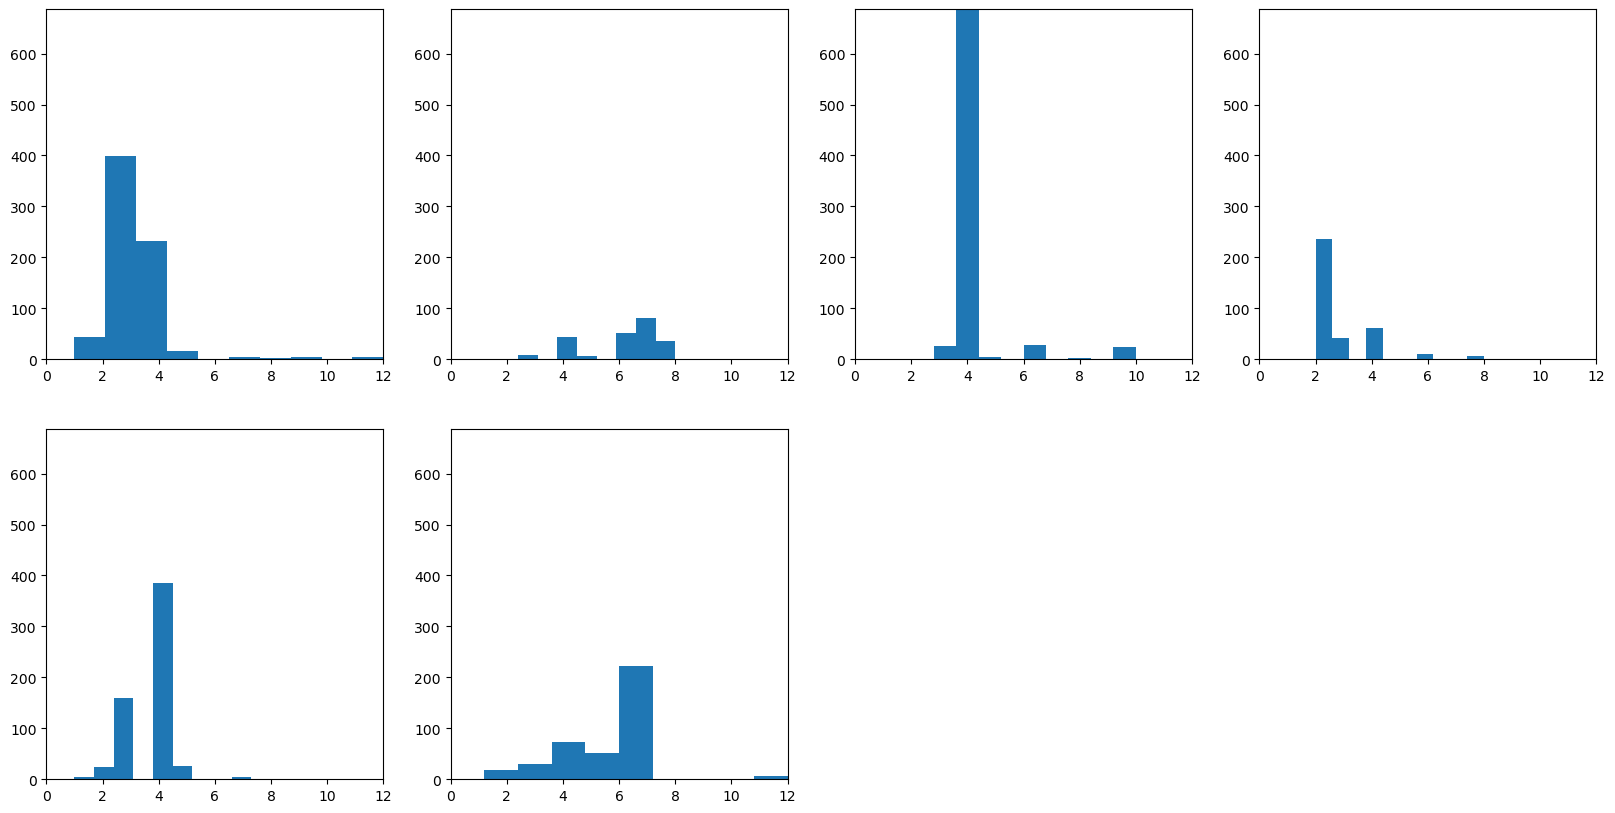

In [275]:
clusters_plotter(joined_df, 'coordination_number')

In [ ]:
joined_df[joined_df.coordination_number > 10]

In [ ]:
cumulative_plotter(joined_df, 'coordination_number')

## Dimensionality

In [857]:
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.analysis.dimensionality import get_dimensionality_cheon, get_dimensionality_gorai, get_dimensionality_larsen
from tqdm import tqdm

dim_cheon = []
dim_gorai = []
dim_larsen = []
for _, entry in tqdm(joined.iterrows()):
    structure = entry.structure
    bonded_structure = CrystalNN(search_cutoff=4).get_bonded_structure(structure)
    dim_cheon.append(get_dimensionality_cheon(structure))
    dim_gorai.append(get_dimensionality_gorai(structure))
    dim_larsen.append(get_dimensionality_larsen(bonded_structure))
joined_df['dim_cheon'] = dim_cheon
joined_df['dim_gorai'] = dim_gorai
joined_df['dim_larsen'] = dim_larsen

0it [00:00, ?it/s]No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
203it [16:43,  4.94s/it]


KeyboardInterrupt: 

Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.


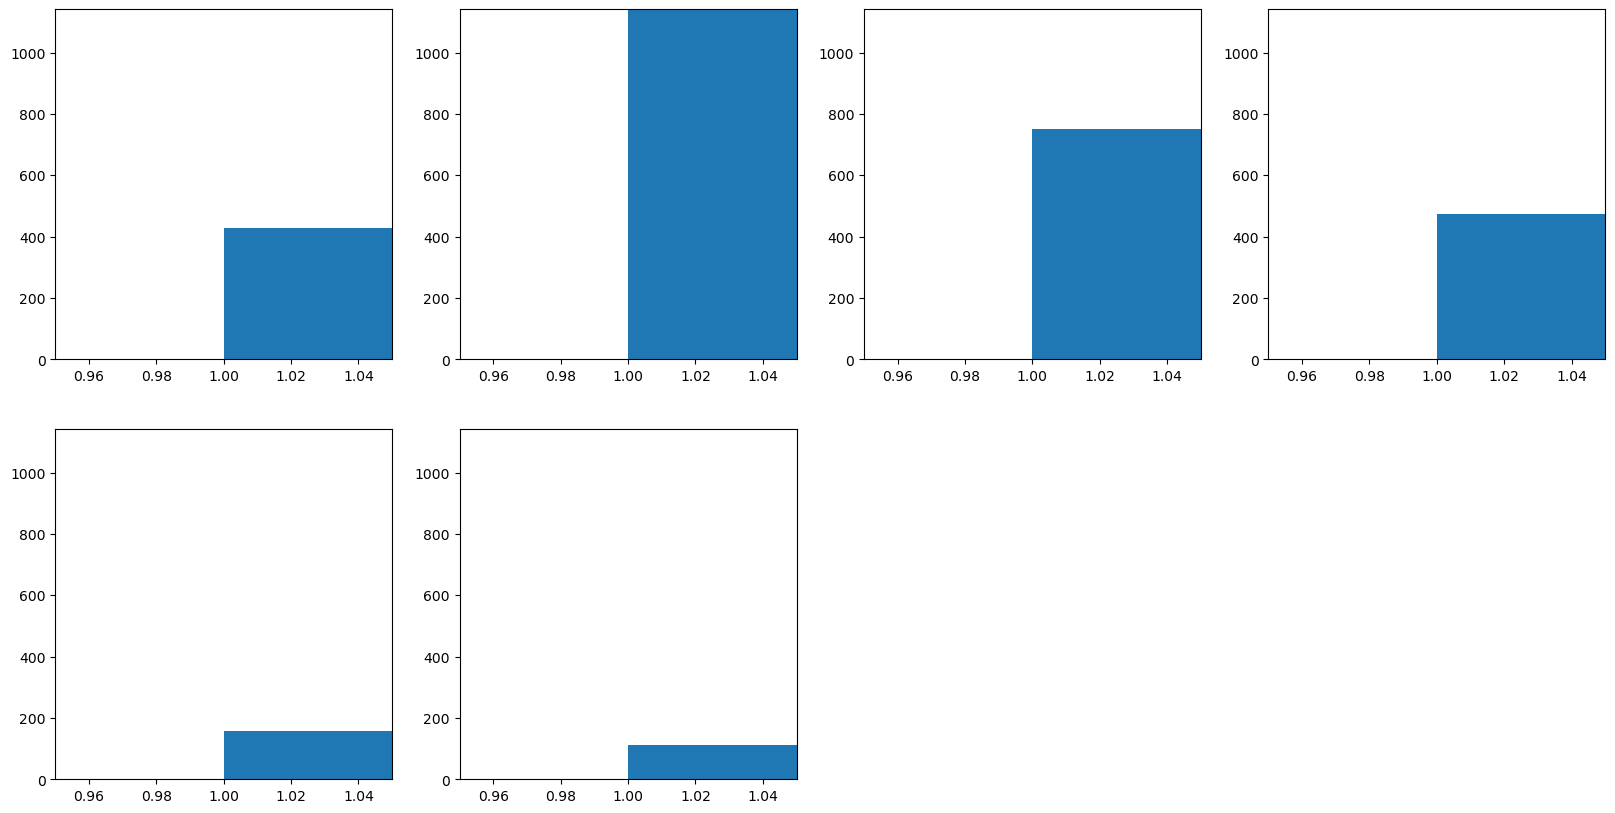

In [856]:
clusters_plotter(joined_df, 'dim_larsen')

## Fraction of structures with >1 site with sites in different clusters

In [877]:
counts = 0
total = 0
for _, entry in structure_df.iterrows():
    cif_filename = entry.cif_filename
    site_df = environment_df[environment_df.cif_filename == cif_filename]
    if len(site_df) > 1:
        total += 1
        if len(set(site_df.cluster_index)) > 1:
            counts += 1
print(counts/total)

0.24236641221374045
